In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from os.path import join
from scipy import stats
from scipy import special

%matplotlib inline

#data = pd.read_csv("data.csv")
#dataw_genres = pd.read_csv("data_w_genres.csv")

#data.info() ## There is no null value.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data_custom.csv")
data.head(2)

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
0,0,0.991,Mamie Smith,0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.993,Mamie Smith,0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.519,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Machine Learning



##Prediction of Song Popularity
Take the target and features seperately.

In [ ]:
target = data['popularity']
features = data.drop(columns = ['Unnamed: 0', 'popularity','artists','id','name'])

features.head(2), target[:3], len(target)

(   acousticness  danceability  duration_ms  ...  swing  funk  hip hop
 0         0.991         0.598       168333  ...    0.0   0.0      0.0
 1         0.993         0.647       163827  ...    0.0   0.0      0.0
 
 [2 rows x 44 columns], 0    12
 1     4
 2     5
 Name: popularity, dtype: int64, 173600)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
# 80% training, 20% for testing. Cross validation will be used for validation.  
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.20)

Let's start with the most basic using LinearRegression

###Linear Regression

In [ ]:
#1- linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_train)

In [ ]:
print("Train accuracy: ",r2_score(y_train,pred))

Train accuracy:  0.4228277776360426


In [ ]:
def crossValidate(estimator, cv = 5, X_train = X_train, y_train = y_train): # We will use this a lot. So functionalizing makes sense
  print("Applying cross validation on", cv, "folds...")

  score_dict = cross_validate(estimator, X_train, y_train, cv=cv, scoring = 'r2', return_train_score=True)

  print("\nAverage train accuracy: ", score_dict['train_score'].mean())
  print("Average validation accuracy: ", score_dict['test_score'].mean())

  return score_dict['train_score'].mean(), score_dict['test_score'].mean()

In [ ]:
_,_ = crossValidate(lr, 5)

Applying cross validation on 5 folds...

Average train accuracy:  0.42286098593120236
Average validation accuracy:  0.4224871209592001


We may conclude that there is no over-fitting. Also we can say that LinearRegression performs poorly.

In [ ]:
pred_test = lr.predict(X_test)
print("Test accuracy: ",r2_score(y_test, pred_test))

Test accuracy:  0.4153810477832821


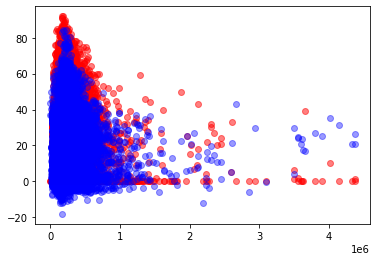

In [ ]:
#lr visualization
plt.scatter(X_test['duration_ms'], y_test, color = 'red', alpha = 0.5)
plt.scatter(X_test['duration_ms'], pred_test, color = 'blue', alpha = 0.4)
plt.show()

###Polynomial Regression
Let's continue with polynomial regression with different degrees
>
Since some variables has so large values, i.e year, they have an exploding effect on degrees greater than 3. Thus, the kernel shuts down due to usage of RAM. Then, we decided to scale down all values to avoid this problem.

In [ ]:
cols_to_scale = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo','valence','year',]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[cols_to_scale])
scaled_data[0]

array([ 1.29350715,  0.34789409, -0.43417385, -0.94887343, -0.27042285,
       -0.58859854, -0.05825708,  0.93069376, -0.15522909, -1.53624326,
       -0.62448305, -0.06720302,  1.08905831,  0.41392543, -1.94016619])

In [ ]:
scaled_df = pd.DataFrame(scaled_data, index=data[cols_to_scale].index, columns=data[cols_to_scale].columns)
scaled_df.min(),"--", scaled_df.max()

(acousticness       -1.313622
 danceability       -3.047666
 duration_ms        -1.535128
 energy             -1.769934
 explicit           -0.270423
 instrumentalness   -0.590158
 key                -1.479401
 liveness           -1.170093
 loudness           -8.475962
 mode               -1.536243
 popularity         -1.172788
 speechiness        -0.579976
 tempo              -3.866599
 valence            -1.982431
 year               -1.940166
 dtype: float64, '--', acousticness         1.306661
 danceability         2.562390
 duration_ms         34.400814
 energy               1.895514
 explicit             3.697912
 instrumentalness     2.396868
 key                  1.647116
 liveness             4.372881
 loudness             2.739955
 mode                 0.650939
 popularity           3.396418
 speechiness          4.739498
 tempo                4.179604
 valence              1.797311
 year                 1.749264
 dtype: float64)

Scaling down features helped a lot. However, duration_ms column has still huge max value.
>
MinMaxScaler may help us in such case

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-2, 2))
scaled_data = scaler.fit_transform(data[cols_to_scale])

scaled_df = pd.DataFrame(scaled_data, index=data[cols_to_scale].index, columns=data[cols_to_scale].columns)

target = scaled_df['popularity']
features = scaled_df.drop(columns = ['popularity'])

# 80% training, 20% for testing. Cross validation will be used for validation.  
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.20)

In [ ]:
#2- polynomial regression nth degree
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict
score_list = [] # To keep track scores

In [ ]:
n_degree = 2
pr = PolynomialFeatures(degree = n_degree)
x_poly = pr.fit_transform(X_train)      #polinamal dunyayı lineere cevirme

lr2 = LinearRegression()          #lineere cevrilen polinamal verileri lineer regresyonda isleme
lr2.fit(x_poly, y_train)
pred2 = lr2.predict(x_poly)

score_dict = defaultdict()
score_dict['degree'] = n_degree
score_dict['train_score'] = r2_score(y_train,pred2)

print("\nPolynomial regression with", n_degree, "degree. Train accuracy: ",r2_score(y_train,pred2))

score_dict['cross_train_score'], score_dict['cross_validation_score'] = crossValidate(lr2, 5, x_poly)
score_list.append(score_dict)


Polynomial regression with 2 degree. Train accuracy:  0.5184213198607722
Applying cross validation on 5 folds...

Average train accuracy:  0.5185354232183231
Average validation accuracy:  0.5173542209410503


In [ ]:
x_test_poly = pr.transform(X_test)
pred_test2 = lr2.predict(x_test_poly)

print("\nPolynomial regression with", n_degree, "degree. Test accuracy: ",r2_score(y_test,pred_test2))


Polynomial regression with 2 degree. Test accuracy:  0.512859714725046


Seemed to be no over-fitting. So we continued with testing. Test score is also satisfying compared to training altough general score is poor.

In [ ]:
#@title n_degree = 3 & cv = 4
n_degree = 3
pr = PolynomialFeatures(degree = n_degree)
x_poly = pr.fit_transform(X_train)      #polinamal dunyayı lineere cevirme

lr2 = LinearRegression()          #lineere cevrilen polinamal verileri lineer regresyonda isleme
lr2.fit(x_poly, y_train)
pred2 = lr2.predict(x_poly)

score_dict = defaultdict()
score_dict['degree'] = n_degree
score_dict['train_score'] = r2_score(y_train,pred2)

print("\nPolynomial regression with", n_degree, "degree. Train accuracy: ",r2_score(y_train,pred2))

score_dict['cross_train_score'], score_dict['cross_validation_score'] = crossValidate(lr2, 4, x_poly)
score_list.append(score_dict)


Polynomial regression with 3 degree. Train accuracy:  0.587983847301557
Applying cross validation on 4 folds...

Average train accuracy:  0.5887501050154268
Average validation accuracy:  0.5819260407526045


In [ ]:
x_test_poly = pr.transform(X_test)
pred_test2 = lr2.predict(x_test_poly)

print("\nPolynomial regression with", n_degree, "degree. Test accuracy: ",r2_score(y_test,pred_test2))


Polynomial regression with 3 degree. Test accuracy:  0.5789796932520735


Seemed to be no over-fitting. So we continued with testing. Test score is also satisfying compared to training and it is better than n_degree = 2.

We can not avoid exceeding RAM usage without narrowing the scale range for n_degree = 4.

In [ ]:
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled_data = scaler.fit_transform(data[cols_to_scale])

scaled_df = pd.DataFrame(scaled_data, index=data[cols_to_scale].index, columns=data[cols_to_scale].columns)

target = scaled_df['popularity']
features = scaled_df.drop(columns = ['popularity'])

# 60% training, 40% for testing (increased test propotion due to lack of memory). Cross validation will be used for validation.  
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.40)

In [ ]:
#@title n_degree = 4 & cv = 3
n_degree = 4
pr = PolynomialFeatures(degree = n_degree)
x_poly = pr.fit_transform(X_train)      #polinamal dunyayı lineere cevirme

lr2 = LinearRegression()          #lineere cevrilen polinamal verileri lineer regresyonda isleme
lr2.fit(x_poly, y_train)
pred2 = lr2.predict(x_poly)

score_dict = defaultdict()
score_dict['degree'] = n_degree
score_dict['train_score'] = r2_score(y_train,pred2)

print("\nPolynomial regression with", n_degree, "degree. Train accuracy: ",r2_score(y_train,pred2))

score_dict['cross_train_score'], score_dict['cross_validation_score'] = crossValidate(lr2, 3, x_poly, y_train)
score_list.append(score_dict)


Polynomial regression with 4 degree. Train accuracy:  0.616942053316628
Applying cross validation on 3 folds...

Average train accuracy:  0.6227532482005528
Average validation accuracy:  0.3096783598092373


In [ ]:
x_test_poly = pr.transform(X_test)
pred_test2 = lr2.predict(x_test_poly)

print("\nPolynomial regression with", n_degree, "degree. Test accuracy: ",r2_score(y_test,pred_test2))


Polynomial regression with 4 degree. Test accuracy:  0.5358516366373646


There seems to be over-fitting while training. Also, test score is very poor compared to n_degree = 3. This may due to lack of training dataset propotion (unfortunately we can not make it bigger).

In [ ]:
score_list_df = pd.DataFrame(score_list)
score_list_df

,degree,train_score,cross_train_score,cross_validation_score
0,2,0.518421,0.518535,0.517354
1,3,0.587984,0.588750,0.581926
2,4,0.616942,0.622753,0.309678


In [ ]:
test_scores = [0.512859714725046, 0.5789796932520735, 0.5358516366373646] # Forgot to track those values, just copied from the outputs

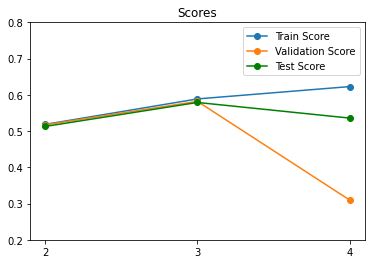

In [ ]:
plt.plot(score_list_df['degree'],score_list_df['cross_train_score'], marker = 'o')
plt.plot(score_list_df['degree'],score_list_df['cross_validation_score'], marker = 'o')
plt.plot(score_list_df['degree'],test_scores, marker = 'o', color = 'g')
plt.ylim(0.2, 0.8)
plt.xlim(1.9, 4.1)

plt.xticks(ticks = score_list_df['degree'], labels = [2,3,4])
plt.title('Scores')
plt.legend(["Train Score", "Validation Score", 'Test Score'])

plt.show()

###Random Forest Regressor

In [ ]:
target = data['popularity']
features = data.drop(columns = ['Unnamed: 0', 'popularity','artists','id','name'])

# 80% training, 20% for testing. Cross validation will be used for validation.  
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.20)

In [ ]:
#6- random forest regression
from sklearn.ensemble import RandomForestRegressor
n_estimators_range = range(2, 11)
rfr_score_list = []

In [ ]:
for n_estimators in n_estimators_range:
  rfr = RandomForestRegressor(n_estimators = n_estimators, random_state = 42)

  rfr.fit(X_train,y_train)
  pred = rfr.predict(X_train)
  print("\nRandom forest regression with", n_estimators, "n_estimators. Train accuracy: ",r2_score(y_train,pred))

  score_dict = {}
  score_dict['train_score'] = r2_score(y_train,pred)

  score_dict['cross_train_score'], score_dict['cross_validation_score'] = crossValidate(rfr, 5, X_train, y_train)
  rfr_score_list.append(score_dict)



Random forest regression with 2 n_estimators. Train accuracy:  0.8641387322450316
Applying cross validation on 5 folds...

Average train accuracy:  0.861932578550428
Average validation accuracy:  0.530112435314366

Random forest regression with 3 n_estimators. Train accuracy:  0.8958097298958035
Applying cross validation on 5 folds...

Average train accuracy:  0.8940140291652247
Average validation accuracy:  0.5856856752205426

Random forest regression with 4 n_estimators. Train accuracy:  0.9110317281363867
Applying cross validation on 5 folds...

Average train accuracy:  0.909251616805185
Average validation accuracy:  0.6133048633213699

Random forest regression with 5 n_estimators. Train accuracy:  0.9200145554520854
Applying cross validation on 5 folds...

Average train accuracy:  0.9188202392508098
Average validation accuracy:  0.6305122160145672

Random forest regression with 6 n_estimators. Train accuracy:  0.9261737568546191
Applying cross validation on 5 folds...

Average tra

It is obvious that there is over-fitting. Let's try max_depth = 15 (intuitively selected as we have 15 features beside genres)

In [ ]:
rfr_score_list = []
for n_estimators in n_estimators_range:
  rfr = RandomForestRegressor(n_estimators = n_estimators, random_state = 42, max_depth = 15)

  rfr.fit(X_train,y_train)
  pred = rfr.predict(X_train)
  print("\nRandom forest regression with", n_estimators, "n_estimators. Train accuracy: ",r2_score(y_train,pred))

  score_dict = {}
  score_dict['train_score'] = r2_score(y_train,pred)

  score_dict['cross_train_score'], score_dict['cross_validation_score'] = crossValidate(rfr, 5, X_train, y_train)
  score_dict['test_score'] = r2_score(y_test, rfr.predict(X_test))
  rfr_score_list.append(score_dict)



Random forest regression with 2 n_estimators. Train accuracy:  0.7384947842124716
Applying cross validation on 5 folds...

Average train accuracy:  0.7397677460475495
Average validation accuracy:  0.6269867776888993

Random forest regression with 3 n_estimators. Train accuracy:  0.7538504228671933
Applying cross validation on 5 folds...

Average train accuracy:  0.755872760269811
Average validation accuracy:  0.6463228788212227

Random forest regression with 4 n_estimators. Train accuracy:  0.7603611233872452
Applying cross validation on 5 folds...

Average train accuracy:  0.7627154190378689
Average validation accuracy:  0.6556005324009802

Random forest regression with 5 n_estimators. Train accuracy:  0.7624168464821258
Applying cross validation on 5 folds...

Average train accuracy:  0.7670683099863501
Average validation accuracy:  0.6614826821154524

Random forest regression with 6 n_estimators. Train accuracy:  0.7662808202203888
Applying cross validation on 5 folds...

Average t

In [ ]:
score_list_df = pd.DataFrame(rfr_score_list)

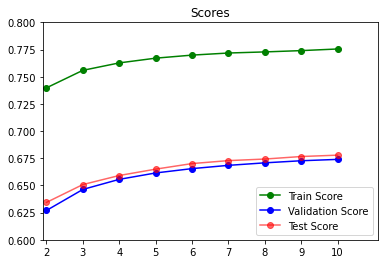

In [ ]:
plt.plot(n_estimators_range,score_list_df['cross_train_score'], marker = 'o', color = 'g')
plt.plot(n_estimators_range,score_list_df['cross_validation_score'], marker = 'o', color = 'b')
plt.plot(n_estimators_range,score_list_df['test_score'], marker = 'o', alpha = 0.6, color = 'r')

plt.ylim(0.6, 0.8)
plt.xlim(1.9,11.1)

plt.xticks(ticks = n_estimators_range, labels = [2,3,4,5,6,7,8,9,10,11])
plt.title('Scores')
plt.legend(["Train Score", "Validation Score", "Test Score"])
plt.show()

We improved our model in terms of validation accuracy and over-fitting. It seems to have more n_estimators lead to more accuracy.
>
 We can use GridSearchCV to estimate best model with selected n_estimators, max_depth and min_samples_split.

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = {'n_estimators': [8, 9, 10, 11, 12], 'max_depth': [9, 10, 11, 12, 13, 14], 'min_samples_split': [1, 2, 3]}

In [ ]:
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)
regressor = clf.best_estimator_

clf.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 40.6min finished


{'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 12}

In [ ]:
pred_train = regressor.predict(X_train)
print("\nRandom forest regression after GridSearchCV, Train accuracy: ", r2_score(y_train, pred_train))


Random forest regression after GridSearchCV, Train accuracy:  0.7502591290784982


In [ ]:
pred_test = regressor.predict(X_test)
print("\nRandom forest regression after GridSearchCV, Test accuracy: ", r2_score(y_test, pred_test))


Random forest regression after GridSearchCV, Test accuracy:  0.6768706751949023


We have found the best results so far using GridSearchCV. It minimized over-fitting and maximized test accuracy. On the other hand, it took a long time to find best parameters.

##Song Recommendation System
We need to preprocess the data before getting into recommendation system.
> 
We don't need genres explicitly as we can extract same information from other variables.

In [ ]:
data.head(2)

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
0,0,0.991,Mamie Smith,0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.993,Mamie Smith,0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.519,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = data.loc[:,'acousticness':'year'] # Most valuable variables, 
data.head(2)                             # where real info stems from.

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year
0,0.991,Mamie Smith,0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,1920
1,0.993,Mamie Smith,0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.519,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689,1920


In [ ]:
data.drop(columns = ['id'], inplace = True) # We do not need id column.
data.head(2)

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year
0,0.991,Mamie Smith,0.598,168333,0.224,0,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,1920
1,0.993,Mamie Smith,0.647,163827,0.186,0,0.000018,0,0.519,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689,1920


Since we are looking for Nearest Neighbors, we should scale all values to boost performance.

In [ ]:
cols_to_scale = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo','valence','year',]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[cols_to_scale])
scaled_data.shape, scaled_data.min(), scaled_data.max()

((173600, 15), -8.475962126167142, 34.40081399616603)

In [ ]:
from scipy.spatial.distance import cdist
from collections import defaultdict

In [ ]:
def getMeanVector(song_list):
    """
    Takes list of songs as input.

    Returns mean values of the variables of each song.

    """
    song_vectors = []
    
    for song in song_list:
        song_data = data[(data['name'] == song['name']) & (data['year'] == song['year']//10*10)].iloc[0]
        
        if song_data is None:
            print('Warning: {} does not exist in database'.format(song['name']))
            continue
        song_vector = song_data[cols_to_scale].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

In [ ]:
def flattenDictList(dict_list):
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict

In [ ]:
def recommendSongs(song_list, n_songs = 5):
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flattenDictList(song_list)
    
    song_center = getMeanVector(song_list)
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))

    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]

    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
song_list =   [{'name': 'Come As You Are', 'year':1991},
               {'name': 'Smells Like Teen Spirit', 'year': 1991},
               {'name': 'Lithium', 'year': 1992},
               {'name': 'All Apologies', 'year': 1993},
               {'name': 'Stay Away', 'year': 1993}]

n_songs = 10

recommendSongs(song_list = song_list, n_songs = n_songs)

[{'artists': 'ZZ Top',
  'name': 'Sharp Dressed Man - 2008 Remaster',
  'year': 1980},
 {'artists': 'Rascal Flatts', 'name': 'My Wish', 'year': 2000},
 {'artists': 'Nickelback', 'name': 'Far Away', 'year': 2000},
 {'artists': "Guns N' Roses",
  'name': "Knockin' On Heaven's Door",
  'year': 1990},
 {'artists': 'Bon Jovi', 'name': 'Have A Nice Day', 'year': 2000},
 {'artists': 'Brooks & Dunn', 'name': 'Red Dirt Road', 'year': 2000},
 {'artists': 'Cher', 'name': 'Believe', 'year': 1990},
 {'artists': 'Bruce Springsteen', 'name': 'Born in the U.S.A.', 'year': 1980},
 {'artists': 'RBD', 'name': 'Nuestro Amor', 'year': 2000}]

Let's use MinMaxScaler instead of StandartScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[cols_to_scale])
scaled_data.shape, scaled_data.min(), scaled_data.max()

((173600, 15), 0.0, 1.0)

In [ ]:
recommendSongs(song_list = song_list, n_songs = n_songs)

[{'artists': 'Elle King', 'name': "Ex's & Oh's", 'year': 2010},
 {'artists': 'Panic! At The Disco', 'name': 'This Is Gospel', 'year': 2010},
 {'artists': 'Fall Out Boy', 'name': "Sugar, We're Goin Down", 'year': 2000},
 {'artists': 'Skillet', 'name': 'Monster', 'year': 2000},
 {'artists': 'TWICE', 'name': 'CHEER UP', 'year': 2010},
 {'artists': 'I Prevail', 'name': 'Scars', 'year': 2010},
 {'artists': 'Coldplay', 'name': 'Adventure of a Lifetime', 'year': 2010},
 {'artists': 'Paramore', 'name': 'Still into You', 'year': 2010},
 {'artists': 'Ozuna', 'name': 'Caramelo', 'year': 2020},
 {'artists': 'Train', 'name': '50 Ways to Say Goodbye', 'year': 2010}]

The way of scaling affects the results. Actually, these recommendations seems to be worse than the StandardScaler.
>
This could be due to default range of MinMaxScaler, which is (0,1). The range is so narrow that it may lead to **vanish** actual effectiveness, weights of variables.
>
Let's make the range between (-1,1) and try again.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(data[cols_to_scale])
scaled_data.shape, scaled_data.min(), scaled_data.max()

((173600, 15), -1.0, 1.0000000000000002)

In [ ]:
recommendSongs(song_list = song_list, n_songs = n_songs)

[{'artists': 'ZZ Top',
  'name': 'Sharp Dressed Man - 2008 Remaster',
  'year': 1980},
 {'artists': 'Rascal Flatts', 'name': 'My Wish', 'year': 2000},
 {'artists': 'Brooks & Dunn', 'name': 'Red Dirt Road', 'year': 2000},
 {'artists': 'Bon Jovi', 'name': 'Have A Nice Day', 'year': 2000},
 {'artists': 'Kings of Leon', 'name': 'Notion', 'year': 2000},
 {'artists': 'Paramore', 'name': 'My Heart', 'year': 2000},
 {'artists': 'Cher', 'name': 'Believe', 'year': 1990},
 {'artists': 'Nickelback', 'name': 'Never Gonna Be Alone', 'year': 2000},
 {'artists': "Guns N' Roses",
  'name': "Knockin' On Heaven's Door",
  'year': 1990},
 {'artists': 'One Direction', 'name': 'Little Black Dress', 'year': 2010}]

These results seems to be more reasonable and much closer to the results of StandardScaler.

# Hypothesis Testing

In [ ]:
data.head()

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
0,0,0.991,Mamie Smith,0.598,168333,0.2240,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.993,Mamie Smith,0.647,163827,0.1860,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.519,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.992,Mamie Smith,0.782,195200,0.0573,0,5DlCyqLyX2AOVDTjjkDZ8x,0.000002,5,0.176,-12.453,1,Don't You Advertise Your Man,5,0.0592,85.652,0.487,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.995,Mamie Smith,0.482,198000,0.2290,0,0lqEx4vktZP1y9hnwfF27Y,0.000061,7,0.549,-12.619,1,Kansas City Man Blues - 78rpm Version,4,0.0812,77.232,0.461,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.992,Mamie Smith,0.574,189800,0.1380,0,4HYmmG8uHL2hP4zSFWavKF,0.000492,3,0.233,-14.171,1,Miss Jenny's Ball (aka There'll Be No Freebies...,1,0.1090,158.422,0.764,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Chi-square test 

We apply chi-square test to determine whether there is a relationship between the number of keys of the songs and their mode type(mode 0 or mode 1) or not.

In [ ]:
crosstab_df = pd.crosstab(data["mode"],data["key"])
crosstab_df

key,0,1,2,3,4,5,6,7,8,9,10,11
mode,,,,,,,,,,,,
0.0,1727,747,1607,633,1394,2223,832,1709,538,1778,1367,1397
1.0,5907,3766,3899,2903,2276,4519,1830,5227,3614,3109,3602,1413


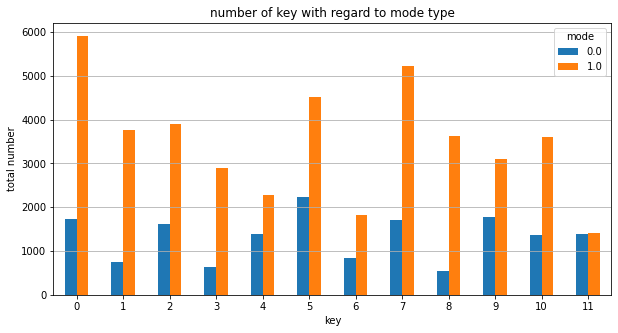

In [ ]:
ax = crosstab_df.T.plot.bar(figsize=(10, 5), rot=0)
ax.set_ylabel("total number")
ax.set_title("number of key with regard to mode type")
ax.grid(axis="y");

In [ ]:
alpha = 0.05
chi2_test_stat, p_value, dof, expected_freqs = stats.chi2_contingency(crosstab_df)

result = "independent" if p_value > alpha else "not independent"
print(f"Mode type and number of keys of songs are {result}")

Mode type and number of keys of songs are not independent


### Sample Hypothesis Test

Hypothesis Test: We want to test whether there is significant differences in terms of popularity of songs for different mode type(mode 0 or mode 1).

$c_1$ = songs whose mode is 0.

$c_2$ = songs whose mode is 1.

**Null Hypothesis ($H_0$)**: Means of popularity for $c_1$ and $c_2$ are same.

$ H_0: \mu_{c_1} = \mu_{c_2}$

**Alternative Hypothesis ($H_A$)**: Means of popularity for $c_1$ and $c_2$ are not same.

$ H_A:$ Means $\mu_{c_1}, \mu_{c_2}$ are not same.

**Significance level**: As most of hypothesis tests assume significance level as `0.05`, we are setting it as `0.05` for our test too.

In [ ]:
class_group = data.groupby(by = "mode")
class_group

In [ ]:
class_group["mode"].value_counts()

mode  mode
0     0        51666
1     1       121934
Name: mode, dtype: int64

Now let's check whether the mode type affect popularity or not



In [ ]:
test_type = "popularity"

not_have_mode = data[data["mode"] == 0][test_type]
have_mode = data[data["mode"] == 1][test_type]

In [ ]:
print(f"mean popularity of songs whose modes are 0: {not_have_mode.mean():.2f}")

mean popularity of songs whose modes are 0: 25.41


In [ ]:
print(f"mean popularity of songs whose modes are 1: {have_mode.mean():.2f}")

mean popularity of songs whose modes are 1: 25.78


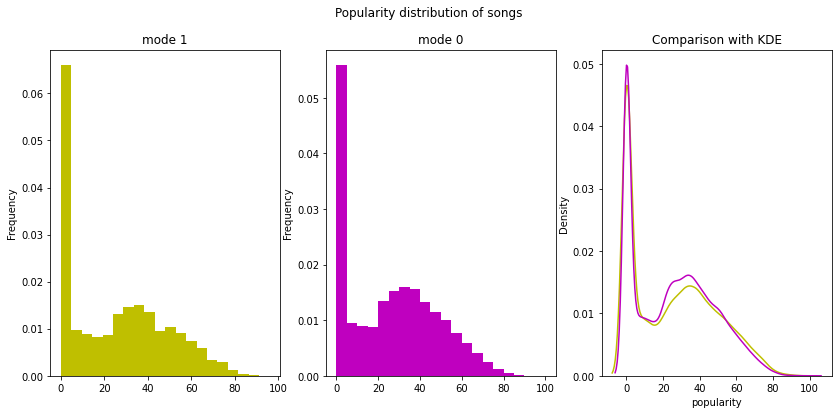

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(14,6))

not_have_mode.plot(kind="hist", ax=ax[0], bins=20, label=0, color="y", density=True)
ax[0].set_title("mode 1")

have_mode.plot(kind="hist", ax=ax[1], bins=20, label=1, color="m", density=True)
ax[1].set_title("mode 0")

sns.kdeplot(not_have_mode, shade=False, ax=ax[2], color="y")
sns.kdeplot(have_mode, shade=False, ax=ax[2], color="m")
ax[2].set_title("Comparison with KDE")

plt.suptitle("Popularity distribution of songs")
plt.show()

In [ ]:
stats.ttest_ind(not_have_mode, have_mode, equal_var=False)

Ttest_indResult(statistic=-3.1747804102519166, pvalue=0.00149999001536047)

since p-value is less than significance level which is 0.05, we can reject the null hypothesis.In addition to that, the test score is negative which indicates that the mean popularity of songs whose mode are 0 is less than whose mode are 1.

Also we can consider mode column as "categorical", in that case we should use ANOVA test

In [ ]:
from scipy.stats import f_oneway

In [ ]:
myNom = data['mode']
myScale = data['popularity']

have_mode = myNom == 1
not_have_mode = myNom == 0
have_mode.head()

0    False
1     True
2     True
3     True
4     True
Name: mode, dtype: bool

In [ ]:
have_scores = myScale[have_mode]
not_have_scores = myScale[not_have_mode]

In [ ]:
f_oneway(have_scores, not_have_scores)

F_onewayResult(statistic=10.544915031290417, pvalue=0.0011653028237659986)

since p-value is less than significance level which is 0.05, we  reject the null hypothesis.

### Sample Hypothesis Test

Now, we want to examine hip hop genre for different time period. In this section, we will compare the main features of hip hop music between 1970-1995 when it was born and was most popular, with the period of 1995-2020. Compared features are valence, energy, tempo, loudness and acousticness which are the most important characteristic properties that determine music.


In [ ]:
df = data.loc[data["year"]>1970][data["year"]<1995][data["hip hop"]==1]
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
73127,73127,0.47300,War,0.818,246333,0.475,0,0wva7TtE4QUkKtnMHP9BpT,0.000000,2,0.0943,-12.880,0,Spill the Wine,55,0.0712,120.378,0.903,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
73134,73134,0.29200,War,0.628,396840,0.415,0,3cES8qbEGbTkrUuAx69THe,0.000287,7,0.0877,-12.552,1,Summer,41,0.0338,105.138,0.686,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
73142,73142,0.03670,War,0.682,244360,0.405,0,0IJPyHBTbGSMPDZHIMYDOF,0.000116,6,0.1440,-12.510,0,The World Is A Ghetto,37,0.0494,91.582,0.401,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
73148,73148,0.45000,War,0.745,203427,0.712,0,5iEkTQq8fl2FWmwOv6wD7E,0.664000,9,0.3590,-11.675,1,Ballero,38,0.0326,122.595,0.724,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
73153,73153,0.63600,War,0.827,245600,0.456,0,12QZZz9J9O4XR6dux8FHDc,0.000007,2,0.0822,-13.202,0,Spill the Wine,29,0.0879,120.429,0.871,1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170093,170093,0.07590,Organized Konfusion,0.883,258507,0.807,0,59Lf7JZarHeKndgFleAHJC,0.000000,1,0.2330,-6.217,1,Let's Organize (feat. Q-Tip),36,0.2360,106.654,0.830,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
172228,172228,0.00248,Tim Dog,0.766,249824,0.596,1,7xPXdN7i2u7ts6vWwCnmcq,0.000055,1,0.1840,-12.973,1,Fuck Compton,34,0.2970,104.576,0.458,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
172264,172264,0.26400,Cub,0.445,80560,0.706,0,4iA8JrFwey2V0A1cZRhZAd,0.801000,9,0.1590,-8.080,1,My Chinchilla,28,0.0367,182.418,0.963,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
172266,172266,0.09530,Freestyle Fellowship,0.660,278400,0.816,0,4paRDS0LDHtb5WvwJ1Ahwb,0.000086,7,0.1550,-7.465,1,Inner City Boundaries,33,0.0965,88.320,0.722,1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_c = data.loc[data["year"]>1995][data["year"]<2020][data["hip hop"]==1]
df_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
84825,84825,0.00293,Bow Wow Wow,0.716,161960,0.956,0,5thnmjW05cx57BQw6jTt6z,0.022000,7,0.0986,-7.387,1,I Want Candy (Re-recorded / Remastered),0,0.0796,109.195,0.6040,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
86478,86478,0.46500,The Sugarhill Gang,0.900,427360,0.845,0,0FWhGmPVxLI6jOVF0wjALa,0.000000,11,0.0724,-7.306,0,Rapper's Delight,54,0.2570,111.187,0.9140,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
91542,91542,0.23200,LL Cool J,0.668,287000,0.806,0,0HJYzGavqzjiKMmm4F0UZv,0.000000,6,0.1800,-3.900,1,Luv U Better,53,0.2390,95.022,0.7210,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
91543,91543,0.26400,LL Cool J,0.707,254373,0.655,0,1RQE33QW6K4YFKGPLHjbcC,0.000000,1,0.1260,-5.704,1,All I Have,48,0.1030,83.087,0.4150,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
91546,91546,0.01530,LL Cool J,0.780,275067,0.824,0,7mXcOogtMp4naepUnMxwNQ,0.000051,5,0.1500,-2.988,0,Paradise,50,0.2000,97.884,0.8450,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172488,172488,0.42000,Guru's Jazzmatazz,0.734,298267,0.544,1,2iYM4CGkoTfsLw9MI5K1AC,0.000000,11,0.0975,-4.786,0,Keep Your Worries,53,0.1940,86.617,0.6690,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
173033,173033,0.03780,YACHT,0.894,251381,0.569,0,1GdkQKNGLMtPaUvtcjOeSj,0.000099,2,0.0636,-7.144,1,Psychic City - Classixx Remix,48,0.0406,110.005,0.8270,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
173210,173210,0.01190,Rocky,0.712,383233,0.721,0,5wLWAxWggPQQoffA9xHKUI,0.900000,7,0.1230,-10.742,1,5h - Soul Six Remix,0,0.0619,131.991,0.0506,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
173303,173303,0.18200,Casey Veggies,0.600,193547,0.721,1,2YYvZyVDx0GxkoAYyHyV24,0.000000,0,0.2560,-4.596,1,Tied Up (feat. DeJ Loaf),55,0.2120,94.939,0.3710,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Firstly, we will start with the comparison of valence and use same process to energy, tempo, loudness, acousticness and popularity respectively.

$c_1$ = valence of hip hop songs between 1970-1995

$c_2$ = valence of hip hop songs between 1995-2020

**Null Hypothesis ($H_0$)**: Means of valence for $c_1$ and $c_2$ are same.

$ H_0: \mu_{c_1} = \mu_{c_2}$

**Alternative Hypothesis ($H_A$)**: Means of valence for $c_1$ and $c_2$ are not same.

$ H_A:$ Means $\mu_{c_1}, \mu_{c_2}$ are not same.

**Significance level**: As most of hypothesis tests assume significance level as `0.05`, we are setting it as `0.05` for our test too.

In [ ]:
df["valence"].mean()

0.624068634840871

In [ ]:
df_c["valence"].mean()

0.5190715215622477

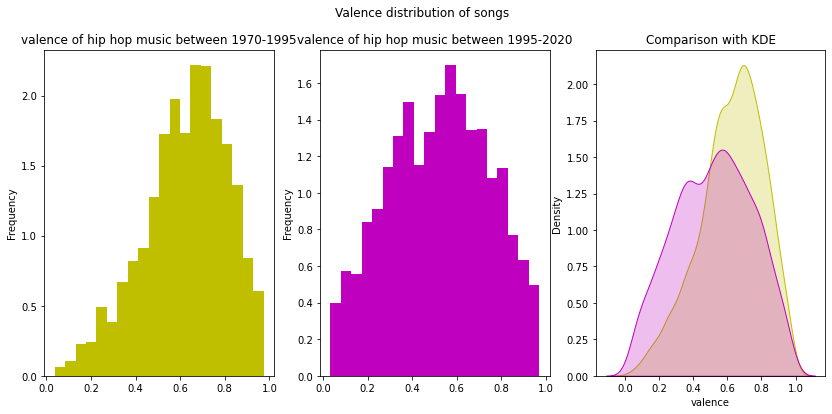

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(14,6))

df["valence"].plot(kind="hist", ax=ax[0], bins=20, label=0, color="y", density=True)
ax[0].set_title("valence of hip hop music between 1970-1995")

df_c["valence"].plot(kind="hist", ax=ax[1], bins=20, label=0, color="m", density=True)
ax[1].set_title("valence of hip hop music between 1995-2020")

sns.kdeplot(df["valence"], shade=True, ax=ax[2], color="y")
sns.kdeplot(df_c["valence"], shade=True, ax=ax[2], color="m")
ax[2].set_title("Comparison with KDE")

plt.suptitle("Valence distribution of hip hop")
plt.show()

In [ ]:
stats.ttest_ind(df["valence"], df_c["valence"], equal_var=False)

Ttest_indResult(statistic=17.627185350015566, pvalue=2.093368245000802e-67)

**Interpreting results:**

> As p-value we obtained is smaller than the threshold significance level 0.05, we can conclude that means of valence are not the same. Here, we reject the null hypothesis.

In [ ]:
df["energy"].mean()

0.6517402428810711

In [ ]:
df_c["energy"].mean()

0.6710162327095213

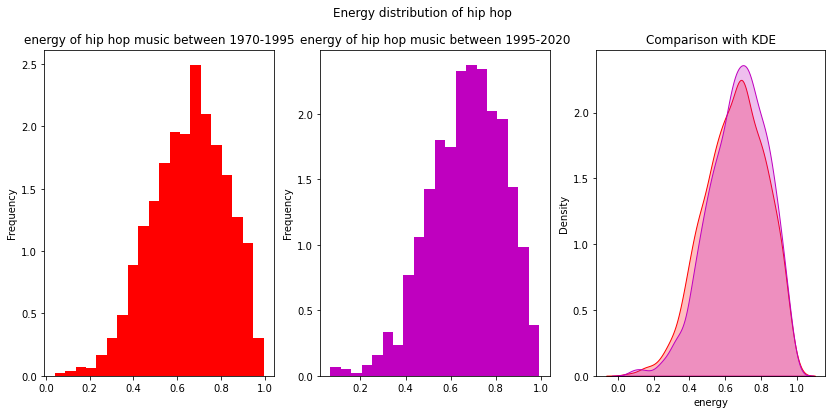

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(14,6))

df["energy"].plot(kind="hist", ax=ax[0], bins=20, label=0, color="r", density=True)
ax[0].set_title("energy of hip hop music between 1970-1995")

df_c["energy"].plot(kind="hist", ax=ax[1], bins=20, label=0, color="m", density=True)
ax[1].set_title("energy of hip hop music between 1995-2020")

sns.kdeplot(df["energy"], shade=True, ax=ax[2], color="r")
sns.kdeplot(df_c["energy"], shade=True, ax=ax[2], color="m")
ax[2].set_title("Comparison with KDE")

plt.suptitle("Energy distribution of hip hop")
plt.show()

In [ ]:
stats.ttest_ind(df["energy"], df_c["energy"], equal_var=False)

Ttest_indResult(statistic=-4.063955439005161, pvalue=4.901644452281947e-05)

**Interpreting results:**

> As p-value we obtained is smaller than the threshold significance level 0.05, we can conclude that means of energy are not the same. Here, we reject the null hypothesis.

In [ ]:
df["tempo"].mean()

111.16903098827474

In [ ]:
df_c["tempo"].mean()

116.68753620829932

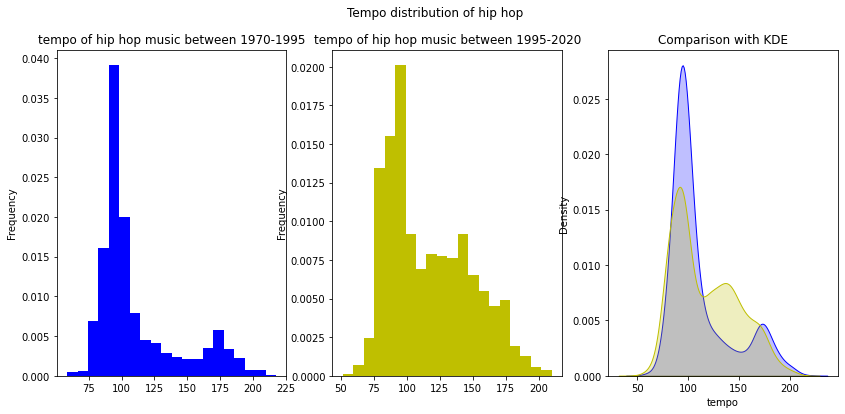

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(14,6))

df["tempo"].plot(kind="hist", ax=ax[0], bins=20, label=0, color="b", density=True)
ax[0].set_title("tempo of hip hop music between 1970-1995")

df_c["tempo"].plot(kind="hist", ax=ax[1], bins=20, label=0, color="y", density=True)
ax[1].set_title("tempo of hip hop music between 1995-2020")

sns.kdeplot(df["tempo"], shade=True, ax=ax[2], color="b")
sns.kdeplot(df_c["tempo"], shade=True, ax=ax[2], color="y")
ax[2].set_title("Comparison with KDE")

plt.suptitle("Tempo distribution of hip hop")
plt.show()

In [ ]:
stats.ttest_ind(df["tempo"], df_c["tempo"], equal_var=False)

Ttest_indResult(statistic=-6.146885281454037, pvalue=8.53569209519831e-10)

**Interpreting results:**

> As p-value we obtained is smaller than the threshold significance level 0.05, we can conclude that means of tempo are not the same. Here, we reject the null hypothesis.

In [ ]:
df["loudness"].mean()

-9.004722780569505

In [ ]:
df_c["loudness"].mean()

-6.447838486574457

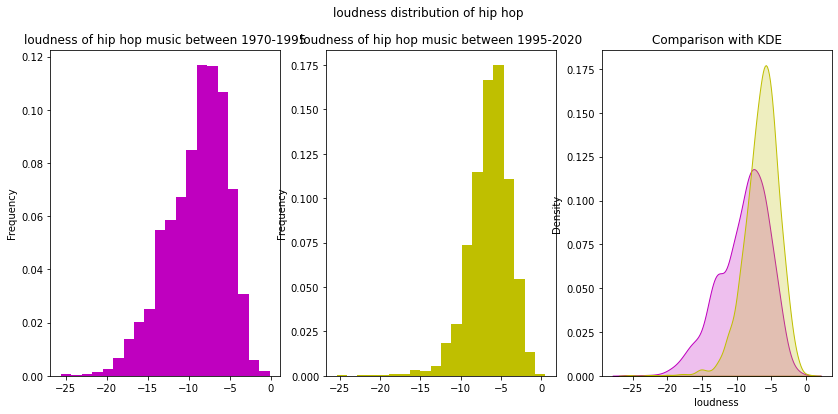

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(14,6))

df["loudness"].plot(kind="hist", ax=ax[0], bins=20, label=0, color="m", density=True)
ax[0].set_title("loudness of hip hop music between 1970-1995")

df_c["loudness"].plot(kind="hist", ax=ax[1], bins=20, label=0, color="y", density=True)
ax[1].set_title("loudness of hip hop music between 1995-2020")

sns.kdeplot(df["loudness"], shade=True, ax=ax[2], color="m")
sns.kdeplot(df_c["loudness"], shade=True, ax=ax[2], color="y")
ax[2].set_title("Comparison with KDE")

plt.suptitle("loudness distribution of hip hop")
plt.show()

In [ ]:
stats.ttest_ind(df["loudness"], df_c["loudness"], equal_var=False)

Ttest_indResult(statistic=-28.156122311208488, pvalue=4.363660422502873e-160)

**Interpreting results:**

> As p-value we obtained is smaller than the threshold significance level 0.05, we can conclude that means of loudness are not the same. Here, we reject the null hypothesis.

In [ ]:
df["acousticness"].mean()

0.13769498110552789

In [ ]:
df_c["acousticness"].mean()

0.17989143445890984

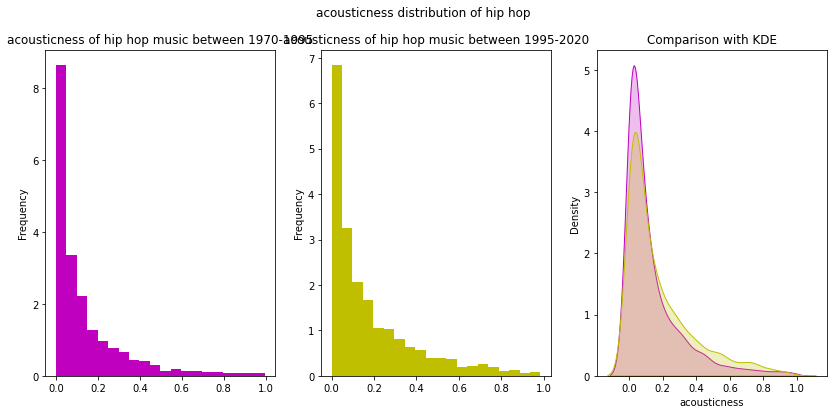

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(14,6))

df["acousticness"].plot(kind="hist", ax=ax[0], bins=20, label=0, color="m", density=True)
ax[0].set_title("acousticness of hip hop music between 1970-1995")

df_c["acousticness"].plot(kind="hist", ax=ax[1], bins=20, label=0, color="y", density=True)
ax[1].set_title("acousticness of hip hop music between 1995-2020")

sns.kdeplot(df["acousticness"], shade=True, ax=ax[2], color="m")
sns.kdeplot(df_c["acousticness"], shade=True, ax=ax[2], color="y")
ax[2].set_title("Comparison with KDE")

plt.suptitle("acousticness distribution of hip hop")
plt.show()

In [ ]:
stats.ttest_ind(df["acousticness"], df_c["acousticness"], equal_var=False)

Ttest_indResult(statistic=-7.668993828321962, pvalue=2.0856800668293223e-14)

**Interpreting results:**

> As p-value we obtained is smaller than the threshold significance level 0.05, we can conclude that means of acousticness are not the same. Here, we reject the null hypothesis.

In [ ]:
df["popularity"].mean()

43.03308207705193

In [ ]:
df_c["popularity"].mean()

56.96013018714402

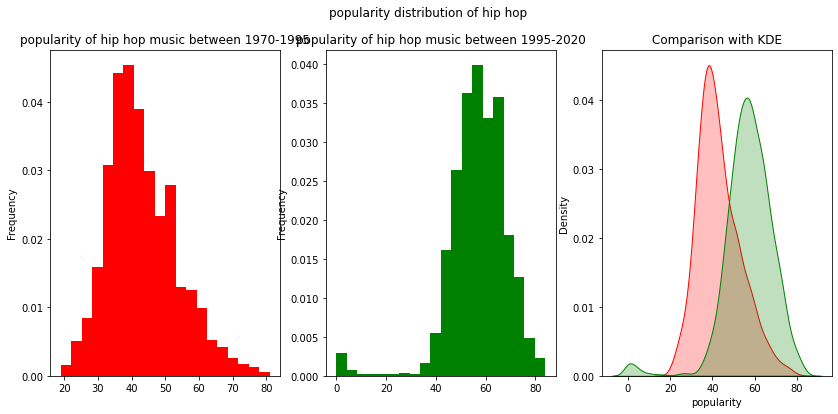

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(14,6))

df["popularity"].plot(kind="hist", ax=ax[0], bins=20, label=0, color="r", density=True)
ax[0].set_title("popularity of hip hop music between 1970-1995")

df_c["popularity"].plot(kind="hist", ax=ax[1], bins=20, label=0, color="g", density=True)
ax[1].set_title("popularity of hip hop music between 1995-2020")

sns.kdeplot(df["popularity"], shade=True, ax=ax[2], color="r")
sns.kdeplot(df_c["popularity"], shade=True, ax=ax[2], color="g")
ax[2].set_title("Comparison with KDE")

plt.suptitle("popularity distribution of hip hop")
plt.show()

In [ ]:
stats.ttest_ind(df["popularity"], df_c["popularity"], equal_var=False)

Ttest_indResult(statistic=-43.99372263626307, pvalue=0.0)

**Interpreting results:**

> As p-value we obtained is smaller than the threshold significance level 0.05, we can conclude that means of popularity are not the same. Here, we reject the null hypothesis.

#0. Prepare Data
##Since we deal a lot with genres, it is convenient to add "genres" feature column to main data. 
As my TA suggested, I'll look at each artists list and its first artist. If it exactly matches one of the artist in the dataset "data_w_genres", I'll append genres list to that row.

In [ ]:
#See that artist column consist of list values
data.tail()

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
24605,24605,0.966,Franz Joseph Haydn,0.435,233693,0.1470,0,0W5IvIhU7fZAPZLOhRaX2E,0.24700,7,0.3660,-17.382,1,"Haydn: String Quartet No. 43 in G Major, Op. 5...",0,0.0371,138.579,0.498,1930.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24606,24606,0.918,Franz Joseph Haydn,0.680,67080,0.3730,0,0oITuo9b6IyJ7mFCwyy6j7,0.42700,0,0.0681,-13.384,1,"Haydn: String Quartet No. 6 in C Major, Op. 1 ...",0,0.1380,79.971,0.387,1930.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24607,24607,0.968,Franz Joseph Haydn,0.220,431227,0.1360,0,0oVv6frZM9gQvjZnFL3B1L,0.12600,7,0.1530,-20.286,1,"Haydn: String Quartet No. 62 in C Major, Op. 7...",0,0.0397,81.679,0.183,1930.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24608,24608,0.952,Franz Joseph Haydn,0.565,202187,0.0629,0,0szbeB1BaK4wYC7H1d7Juy,0.00152,3,0.0927,-16.296,1,"Haydn: String Quartet No. 30 in E-Flat Major, ...",0,0.0499,82.615,0.568,1930.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24609,24609,0.969,Franz Joseph Haydn,0.322,295587,0.1320,0,0xA0rwjh4gPrMAZlugshTR,0.01560,10,0.4340,-16.091,1,"Haydn: String Quartet No. 47 in B-Flat Major, ...",0,0.0484,75.042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Actually they are not list values. They are strings.
data['artists'][10054][0]

'G'

##0.1. Dealing with 'artists' column

In [ ]:
# Cast string type of values to lists for 'artists' column
data['artists'] = data.artists.apply(lambda x: x[1:-1].split(','))
data['artists'][45064][0]

"'Chet Baker'"

In [ ]:
# Take only the first artist in each list (as our TA suggested)
data.loc[:, 'artists'] = data.artists.map(lambda x: x[0])
data.tail()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
174384,0.00917,'DJ Combo',0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,0.00006,6,0.178,-5.089,0,The One,0,2020-12-25,0.0356,125.972,0.186,2020
174385,0.79500,'Alessia Cara',0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.00000,4,0.196,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.228,2021
174386,0.80600,'Roger Fly',0.671,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.92000,4,0.113,-12.393,0,Together,0,2020-12-09,0.0282,108.058,0.714,2020
174387,0.92000,'Taylor Swift',0.462,244000,0.240,1,1gcyHQpBQ1lfXGdhZmWrHP,0.00000,0,0.113,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.320,2021
174388,0.23900,'Roger Fly',0.677,197710,0.460,0,57tgYkWQTNHVFEt6xDKKZj,0.89100,7,0.215,-12.237,1,Improvisations,0,2020-12-09,0.0258,112.208,0.747,2020


In [ ]:
data['artists'][1]

'"Screamin\' Jay Hawkins"'

In [ ]:
# Remove the extra quote marks from the column
data['artists']= data['artists'].str.slice(start = 1)
data['artists'] = data['artists'].str.slice(stop = -1)
data['artists'][1]

"Screamin' Jay Hawkins"

##0.2. Appending 'genres' column to main 'data.csv'



In [ ]:
dataw_genres = dataw_genres[['artists', 'genres']] # No need other columns
dataw_genres.info() # No null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32539 entries, 0 to 32538
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   artists  32539 non-null  object
 1   genres   32539 non-null  object
dtypes: object(2)
memory usage: 508.5+ KB


In [ ]:
dataw_genres['artists'][0] # No extra quote marks

'"Cats" 1981 Original London Cast'

In [ ]:
# This is where we merge two dataframes
# The following code
data = pd.merge(data, dataw_genres, how='inner', on=['artists'])
data.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,173600.000000,173600.000000,1.736000e+05,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000
mean,0.499323,0.536732,2.327701e+05,0.482870,0.068145,0.197574,5.204965,0.211095,-11.744242,0.702385,25.667212,0.105867,117.017184,0.524488,1977.053232
std,0.380113,0.176113,1.484135e+05,0.272819,0.251996,0.334782,3.518302,0.180409,5.693265,0.457211,21.885704,0.182537,30.263679,0.264569,26.936406
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087300,0.414000,1.661070e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.904000,0.000000,1.000000,0.035200,93.938750,0.310000,1955.000000
50%,0.518000,0.548000,2.057730e+05,0.465000,0.000000,0.000526,5.000000,0.138000,-10.828000,1.000000,25.000000,0.045500,115.825000,0.536000,1977.000000
75%,0.895000,0.669000,2.656800e+05,0.711000,0.000000,0.254000,8.000000,0.270000,-7.489000,1.000000,42.000000,0.076400,135.015000,0.744000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173600 entries, 0 to 173599
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      173600 non-null  float64
 1   artists           173600 non-null  object 
 2   danceability      173600 non-null  float64
 3   duration_ms       173600 non-null  int64  
 4   energy            173600 non-null  float64
 5   explicit          173600 non-null  int64  
 6   id                173600 non-null  object 
 7   instrumentalness  173600 non-null  float64
 8   key               173600 non-null  int64  
 9   liveness          173600 non-null  float64
 10  loudness          173600 non-null  float64
 11  mode              173600 non-null  int64  
 12  name              173600 non-null  object 
 13  popularity        173600 non-null  int64  
 14  release_date      173600 non-null  object 
 15  speechiness       173600 non-null  float64
 16  tempo             17

In [ ]:
data.tail()

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
173595,173595,0.8520,[],0.555,174010,0.299,1,7Kvz6HUGWyzKpLewRNykaa,0.690000,9,0.1540,-9.661,1,2020 was the worst year of my fucking life - F...,5,0.5970,109.204,0.618,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173596,173596,0.2820,[],0.608,313253,0.368,0,1AL6lQa6NHNwOKTtVfMFga,0.000002,5,0.0908,-8.539,0,10years vintage - LiVE from 2020.3.5 @EBISU LI...,12,0.0278,125.941,0.212,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173597,173597,0.8250,[],0.695,103343,0.232,0,3JPnVN4wYlmQnuD7OgDx88,0.000000,1,0.5900,-11.010,1,Saint Bernard,68,0.0972,100.488,0.451,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173598,173598,0.0205,[],0.749,197573,0.820,0,3DTqHfTGj1c6y2gDXsTez4,0.000685,7,0.0775,-6.114,1,Regardless,76,0.0478,120.066,0.534,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
173599,173599,0.1250,[],0.755,193555,0.882,1,2GIJ1Lw3ZoYUUYCABVjPcQ,0.001420,10,0.1030,-1.957,0,Baby,1,0.0532,99.984,0.606,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# There is no need to know exact date of release, so just drop the column.
data.drop(['release_date'], axis=1, inplace=True)

##0.3. Dealing with 'year' column 
Working on so many different years does not seem efficient. Rather, just use decades.

In [ ]:
data['year'] = (data['year']//10)*10
data

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
0,0,0.9910,[],0.598,168333,0.2240,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.9930,[],0.647,163827,0.1860,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.9920,[],0.782,195200,0.0573,0,5DlCyqLyX2AOVDTjjkDZ8x,0.000002,5,0.1760,-12.453,1,Don't You Advertise Your Man,5,0.0592,85.652,0.487,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.9950,[],0.482,198000,0.2290,0,0lqEx4vktZP1y9hnwfF27Y,0.000061,7,0.5490,-12.619,1,Kansas City Man Blues - 78rpm Version,4,0.0812,77.232,0.461,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.9920,[],0.574,189800,0.1380,0,4HYmmG8uHL2hP4zSFWavKF,0.000492,3,0.2330,-14.171,1,Miss Jenny's Ball (aka There'll Be No Freebies...,1,0.1090,158.422,0.764,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173595,173595,0.8520,[],0.555,174010,0.2990,1,7Kvz6HUGWyzKpLewRNykaa,0.690000,9,0.1540,-9.661,1,2020 was the worst year of my fucking life - F...,5,0.5970,109.204,0.618,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173596,173596,0.2820,[],0.608,313253,0.3680,0,1AL6lQa6NHNwOKTtVfMFga,0.000002,5,0.0908,-8.539,0,10years vintage - LiVE from 2020.3.5 @EBISU LI...,12,0.0278,125.941,0.212,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173597,173597,0.8250,[],0.695,103343,0.2320,0,3JPnVN4wYlmQnuD7OgDx88,0.000000,1,0.5900,-11.010,1,Saint Bernard,68,0.0972,100.488,0.451,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173598,173598,0.0205,[],0.749,197573,0.8200,0,3DTqHfTGj1c6y2gDXsTez4,0.000685,7,0.0775,-6.114,1,Regardless,76,0.0478,120.066,0.534,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##0.4. Dealing with 'genres' column
 Since this column consist of list values, we should take care of it

In [ ]:
a = 0
for i, l in enumerate(data["genres"]):
    a+=1
    if a == 6:
      break
    print("list",i,"is",type(l))
# See that they are actually 'str'    

list 0 is <class 'str'>
list 1 is <class 'str'>
list 2 is <class 'str'>
list 3 is <class 'str'>
list 4 is <class 'str'>


In [ ]:
data["genres"] = data["genres"].apply(eval)
a = 0
for i, l in enumerate(data["genres"]):
    a+=1
    if a == 6:
      break
    print("list",i,"is",type(l))
# Now they are list, as expected 

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>


The code below creates a dataframe including all different type of genres

In [ ]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [ ]:
to_1D(data["genres"]).value_counts()

deep talent show          9
contemporary country      9
rap                       4
pop rap                   4
pop                       4
dance pop                 4
electropop                4
pop rock                  4
post-teen pop             4
alternative metal         3
trap                      3
philly rap                2
melodic rap               2
nu metal                  2
metalcore                 1
canadian metal            1
canadian rock             1
post-grunge               1
north carolina hip hop    1
industrial rock           1
hard rock                 1
hip hop                   1
conscious hip hop         1
emo rap                   1
rap rock                  1
chicago rap               1
southern hip hop          1
miami hip hop             1
drill                     1
chicago drill             1
industrial metal          1
dtype: int64

In [ ]:
unique_items = to_1D(data["genres"]).value_counts().index

In [ ]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x  else np.nan )
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [ ]:
genres_bool = boolean_df(data["genres"], unique_items)

In [ ]:
genres_bool.head()

,deep talent show,contemporary country,rap,pop rap,pop,dance pop,electropop,pop rock,post-teen pop,alternative metal,trap,philly rap,melodic rap,nu metal,metalcore,canadian metal,canadian rock,post-grunge,north carolina hip hop,industrial rock,hard rock,hip hop,conscious hip hop,emo rap,rap rock,chicago rap,southern hip hop,miami hip hop,drill,chicago drill,industrial metal
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3012 distinct column is a lot. We can define a threshold to drop some of these columns.

In [ ]:
genres_bool = genres_bool.dropna(thresh=5000, axis=1)
genres_bool = genres_bool.fillna(0)
genres_bool.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Empty DataFrame

##0.5 Merging dataframes

In [ ]:
data = pd.concat([data,genres_bool], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173600 entries, 0 to 173599
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   acousticness        173600 non-null  float64
 1   artists             173600 non-null  object 
 2   danceability        173600 non-null  float64
 3   duration_ms         173600 non-null  int64  
 4   energy              173600 non-null  float64
 5   explicit            173600 non-null  int64  
 6   id                  173600 non-null  object 
 7   instrumentalness    173600 non-null  float64
 8   key                 173600 non-null  int64  
 9   liveness            173600 non-null  float64
 10  loudness            173600 non-null  float64
 11  mode                173600 non-null  int64  
 12  name                173600 non-null  object 
 13  popularity          173600 non-null  int64  
 14  speechiness         173600 non-null  float64
 15  tempo               173600 non-nul

In [ ]:
data.head()

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
120535,120535,0.721,[livia Rodrig],0.585,242014,0.436,1,7lPN2DXiMsVn7XUKtOW1CS,0.000013,10,0.1050,-8.761,1,drivers license,100,0.0601,143.874,0.132,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
117368,117368,0.468,[riana Grand],0.737,172325,0.802,1,35mvY5S1H3J2QZyna3TFe0,0.000000,0,0.0931,-4.771,1,positions,96,0.0878,144.015,0.682,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
120935,120935,0.221,[4kGold],0.700,140526,0.722,1,3tjFYV6RSFtuktYl3ZtYcq,0.000000,7,0.2720,-3.558,0,Mood (feat. iann dior),96,0.0369,90.989,0.756,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120862,120862,0.212,[AROL ],0.863,178947,0.666,1,7vrJn5hDSXRmdXoR30KgF1,0.000493,1,0.1030,-4.158,0,BICHOTA,95,0.1520,163.908,0.838,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120942,120942,0.401,[ad Bunn],0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,4,0.1130,-10.059,0,DÁKITI,95,0.0544,109.928,0.145,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##0.6. Save the Custom Data

In [ ]:
data.to_csv('data_custom.csv')

In [ ]:
from google.colab import files
files.download("data_custom.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Visualization

#1. Visualizations descriptive statistics of the dataset

In [ ]:
import pandas as pd
data_custom = pd.read_csv("data_custom.csv")

FileNotFoundError: ignored

In [ ]:
data_custom['popularity'].mean()

25.66721198156682

In [ ]:
data_custom['popularity'].max()

100

In [ ]:
data_custom['popularity'].min()

0.0

In [ ]:
data_custom['popularity'].std()

11.809443843746857

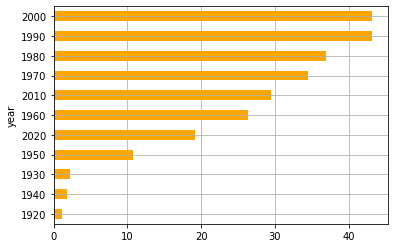

In [ ]:
data_custom.groupby(by = 'year')['popularity'].mean().sort_values().plot.barh(
    grid = True, color = 'orange'
)


Text(0.5, 1.0, 'Number of songs among that years')

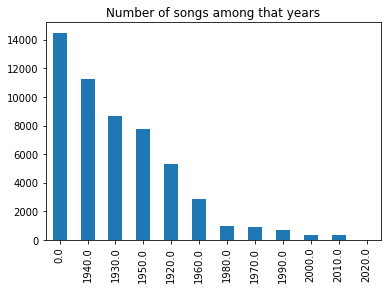

In [ ]:
from scipy import stats

ax = data_custom['year'].value_counts().plot.bar()
ax.set_title('Number of songs among that years')

In [ ]:
data_custom['energy'].mean()

0.482869746351967

In [ ]:
data_custom['energy'].max()

1.0

In [ ]:
data_custom['energy'].min()

0.0

In [ ]:
data_custom['energy'].std()

0.2728187802324705

In [ ]:
data_custom['acousticness'].mean()

0.4993230000171527

In [ ]:
data_custom['acousticness'].max()

0.996

In [ ]:
data_custom['acousticness'].min()

0.0

In [ ]:
data_custom['acousticness'].std()

0.3801126389199941

In [ ]:
data_custom['danceability'].mean()

NameError: ignored

In [ ]:
data_custom['danceability'].max()

0.988

In [ ]:
data_custom['danceability'].min()

0.0

In [ ]:
data_custom['danceability'].std()

0.1761128238568303

In [ ]:
data_custom['duration_ms'].mean()/60000

3.879501550019201

In [ ]:
data_custom['duration_ms'].max()/60000

88.9717

In [ ]:
data_custom['duration_ms'].min()/60000

0.08228333333333333

In [ ]:
data_custom['duration_ms'].std()/60000

2.473559013508784

In [ ]:
df_c = data_custom.copy()
df_c["minutes"] = df_c['duration_ms']/60000
df_c.head()

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop,minutes
0,0,0.991,Mamie Smith,0.598,168333,0.2240,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,0.0936,149.976,0.634,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.805550
1,1,0.993,Mamie Smith,0.647,163827,0.1860,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.519,-12.098,1,Golfing Papa,4,0.1740,97.600,0.689,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.730450
2,2,0.992,Mamie Smith,0.782,195200,0.0573,0,5DlCyqLyX2AOVDTjjkDZ8x,0.000002,5,0.176,-12.453,1,Don't You Advertise Your Man,5,0.0592,85.652,0.487,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.253333
3,3,0.995,Mamie Smith,0.482,198000,0.2290,0,0lqEx4vktZP1y9hnwfF27Y,0.000061,7,0.549,-12.619,1,Kansas City Man Blues - 78rpm Version,4,0.0812,77.232,0.461,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.300000
4,4,0.992,Mamie Smith,0.574,189800,0.1380,0,4HYmmG8uHL2hP4zSFWavKF,0.000492,3,0.233,-14.171,1,Miss Jenny's Ball (aka There'll Be No Freebies...,1,0.1090,158.422,0.764,1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.163333


In [ ]:
def categorize_duration(duration):
  if duration<1:
    return 'less than 1 minute'
  elif 1<=duration<2:
    return '1-2 minutes'
  elif 2<=duration<3:
    return '2-3 minutes'
  elif 3<=duration<4:
    return '3-4 minutes'
  else:
    return 'more than 4 minutes'

df_c['duration category'] = df_c['minutes'].astype(int).apply(categorize_duration)

duration_groups = df_c.groupby(by = 'duration category')

value_dict = {}

for keys,vals in duration_groups.groups.items():
  value_dict[key] = df_c.loc[vals]['popularity'].dropna().values

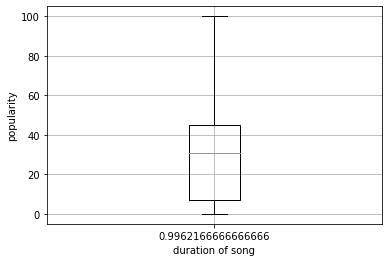

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rates = sorted(value_dict.items(),key=lambda x: np.median(x[1]))

fig,ax = plt.subplots()

ax.boxplot([val[1] for val in rates])

ax.set_xticklabels([rating[0] for rating in rates])
ax.set_ylabel('popularity')
ax.set_xlabel('duration of song')
ax.grid();


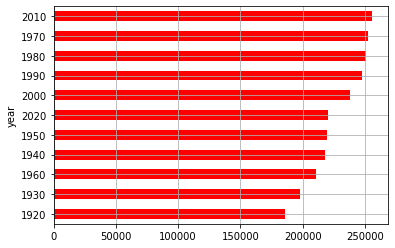

In [ ]:
data_custom.groupby(by = 'year')['duration_ms'].mean().sort_values().plot.barh(
    grid = True, color = 'red'
)

In [ ]:
data_custom['explicit'].mean()

0.06814516129032258

In [ ]:
data_custom['explicit'].max()

1

In [ ]:
data_custom['explicit'].min()

0

In [ ]:
data_custom['explicit'].std()

0.25199556360516956

In [ ]:
data_custom['instrumentalness'].mean()

0.19757367981975033

In [ ]:
data_custom['instrumentalness'].max()

1.0

In [ ]:
data_custom['instrumentalness'].min()

0.0

In [ ]:
data_custom['instrumentalness'].std()

0.3347820872112933

In [ ]:
data_custom['tempo'].mean()

117.01718383640392

In [ ]:
data_custom['tempo'].max()

243.507

In [ ]:
data_custom['tempo'].min()

0.0

In [ ]:
data_custom['tempo'].std()

30.26367909474502

In [ ]:
df = data_custom.sort_values('popularity', ascending = False)
df[["energy","popularity"]].head(50).corr()

,energy,popularity
energy,1.000000,0.189585
popularity,0.189585,1.000000


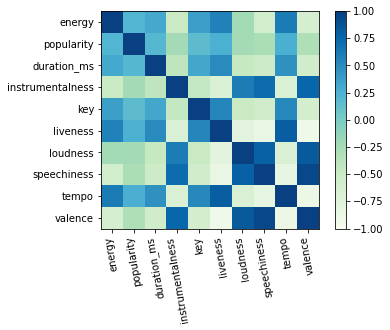

In [ ]:
corrs = data_custom[["acousticness","energy","popularity","duration_ms","instrumentalness","explicit","key","liveness","loudness","mode","speechiness","tempo","valence"]].corr()

plt.imshow(corrs, cmap="GnBu",vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(range(len(corrs)),corrs.columns,rotation=100)
plt.yticks(range(len(corrs)),corrs.index)

plt.show()

#2. Example visualizations of aggregated forms based on features 
##(One example can be grouping the dataset based on genres and comparing distributions or centrality metrics of features for different genres)

##Based on Genres

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


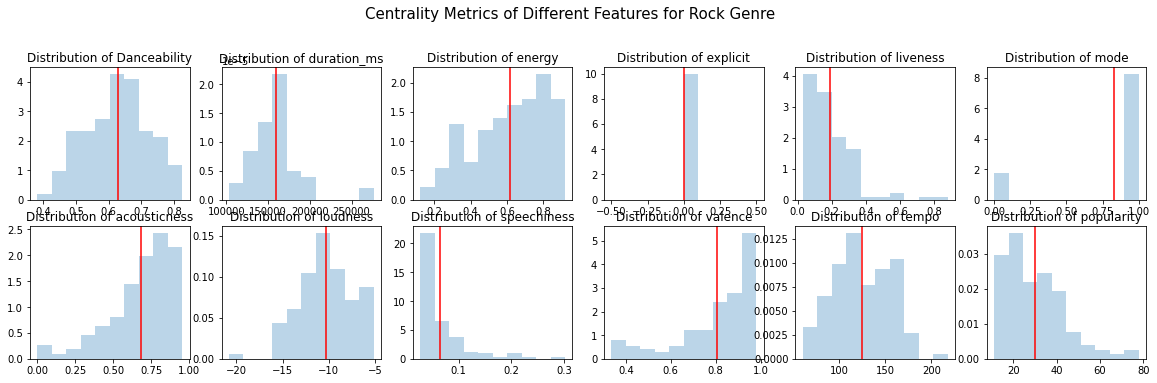

In [ ]:
import matplotlib.pyplot as plt

filter = data_custom["rock"] == True

fig, axes = plt.subplots(2, 6, figsize=(20, 6), constrained_layout=True)
fig.subplots_adjust(top=0.8)
# plot Danceability distribution and its mean
axes[0][0].set_title("Distribution of Danceability")
axes[0][0].hist(data_custom["danceability"][filter], alpha=0.3, density=True)
axes[0][0].axvline(data_custom['danceability'][filter].mean(), 0, 1, c="r")

# plot duration_ms distribution and its mean
axes[0][1].set_title("Distribution of duration_ms")
axes[0][1].hist(data_custom["duration_ms"][filter], alpha=0.3, density=True)
axes[0][1].axvline(data_custom['duration_ms'][filter].mean(), 0, 1, c="r")

# plot energy distribution and its mean
axes[0][2].set_title("Distribution of energy")
axes[0][2].hist(data_custom["energy"][filter], alpha=0.3, density=True)
axes[0][2].axvline(data_custom['energy'][filter].mean(), 0, 1, c="r")

# plot explicit distribution and its mean
axes[0][3].set_title("Distribution of explicit")
axes[0][3].hist(data_custom["explicit"][filter], alpha=0.3, density=True)
axes[0][3].axvline(data_custom['explicit'][filter].mean(), 0, 1, c="r")

# plot liveness distribution and its mean
axes[0][4].set_title("Distribution of liveness")
axes[0][4].hist(data_custom["liveness"][filter], alpha=0.3, density=True)
axes[0][4].axvline(data_custom['liveness'][filter].mean(), 0, 1, c="r")

# plot mode distribution and its mean
axes[0][5].set_title("Distribution of mode")
axes[0][5].hist(data_custom["mode"][filter], alpha=0.3, density=True)
axes[0][5].axvline(data_custom['mode'][filter].mean(), 0, 1, c="r")

# plot acousticness distribution and its mean
axes[1][0].set_title("Distribution of acousticness")
axes[1][0].hist(data_custom["acousticness"][filter], alpha=0.3, density=True)
axes[1][0].axvline(data_custom['acousticness'][filter].mean(), 0, 1, c="r")

# plot loudness distribution and its mean
axes[1][1].set_title("Distribution of loudness")
axes[1][1].hist(data_custom["loudness"][filter], alpha=0.3, density=True)
axes[1][1].axvline(data_custom['loudness'][filter].mean(), 0, 1, c="r")

# plot speechiness distribution and its mean
axes[1][2].set_title("Distribution of speechiness")
axes[1][2].hist(data_custom["speechiness"][filter], alpha=0.3, density=True)
axes[1][2].axvline(data_custom['speechiness'][filter].mean(), 0, 1, c="r")

# plot valence distribution and its mean
axes[1][3].set_title("Distribution of valence")
axes[1][3].hist(data_custom["valence"][filter], alpha=0.3, density=True)
axes[1][3].axvline(data_custom['valence'][filter].mean(), 0, 1, c="r")

# plot tempo distribution and its mean
axes[1][4].set_title("Distribution of tempo")
axes[1][4].hist(data_custom["tempo"][filter], alpha=0.3, density=True)
axes[1][4].axvline(data_custom['tempo'][filter].mean(), 0, 1, c="r")

# plot popularity distribution and its mean
axes[1][5].set_title("Distribution of popularity")
axes[1][5].hist(data_custom["popularity"][filter], alpha=0.3, density=True)
axes[1][5].axvline(data_custom['popularity'][filter].mean(), 0, 1, c="r")


fig.suptitle('Centrality Metrics of Different Features for Rock Genre\n ', fontsize=15, y=0.94)


plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


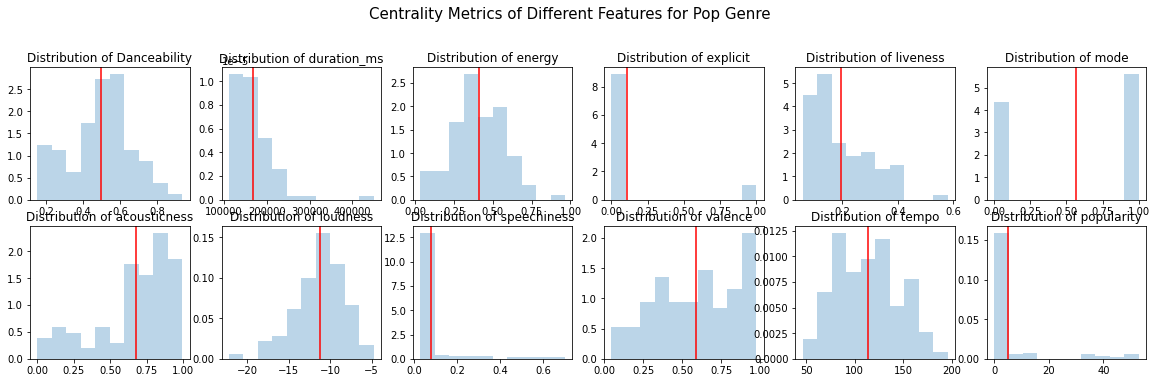

In [ ]:
filter2 = data_custom["pop"] == True

fig, axes = plt.subplots(2, 6, figsize=(20, 6), constrained_layout=True)
fig.subplots_adjust(top=0.8)
# plot Danceability distribution and its mean
axes[0][0].set_title("Distribution of Danceability")
axes[0][0].hist(data_custom["danceability"][filter2], alpha=0.3, density=True)
axes[0][0].axvline(data_custom['danceability'][filter2].mean(), 0, 1, c="r")

# plot duration_ms distribution and its mean
axes[0][1].set_title("Distribution of duration_ms")
axes[0][1].hist(data_custom["duration_ms"][filter2], alpha=0.3, density=True)
axes[0][1].axvline(data_custom['duration_ms'][filter2].mean(), 0, 1, c="r")

# plot energy distribution and its mean
axes[0][2].set_title("Distribution of energy")
axes[0][2].hist(data_custom["energy"][filter2], alpha=0.3, density=True)
axes[0][2].axvline(data_custom['energy'][filter2].mean(), 0, 1, c="r")

# plot explicit distribution and its mean
axes[0][3].set_title("Distribution of explicit")
axes[0][3].hist(data_custom["explicit"][filter2], alpha=0.3, density=True)
axes[0][3].axvline(data_custom['explicit'][filter2].mean(), 0, 1, c="r")

# plot liveness distribution and its mean
axes[0][4].set_title("Distribution of liveness")
axes[0][4].hist(data_custom["liveness"][filter2], alpha=0.3, density=True)
axes[0][4].axvline(data_custom['liveness'][filter2].mean(), 0, 1, c="r")

# plot mode distribution and its mean
axes[0][5].set_title("Distribution of mode")
axes[0][5].hist(data_custom["mode"][filter2], alpha=0.3, density=True)
axes[0][5].axvline(data_custom['mode'][filter2].mean(), 0, 1, c="r")

# plot acousticness distribution and its mean
axes[1][0].set_title("Distribution of acousticness")
axes[1][0].hist(data_custom["acousticness"][filter2], alpha=0.3, density=True)
axes[1][0].axvline(data_custom['acousticness'][filter2].mean(), 0, 1, c="r")

# plot loudness distribution and its mean
axes[1][1].set_title("Distribution of loudness")
axes[1][1].hist(data_custom["loudness"][filter2], alpha=0.3, density=True)
axes[1][1].axvline(data_custom['loudness'][filter2].mean(), 0, 1, c="r")

# plot speechiness distribution and its mean
axes[1][2].set_title("Distribution of speechiness")
axes[1][2].hist(data_custom["speechiness"][filter2], alpha=0.3, density=True)
axes[1][2].axvline(data_custom['speechiness'][filter2].mean(), 0, 1, c="r")

# plot valence distribution and its mean
axes[1][3].set_title("Distribution of valence")
axes[1][3].hist(data_custom["valence"][filter2], alpha=0.3, density=True)
axes[1][3].axvline(data_custom['valence'][filter2].mean(), 0, 1, c="r")

# plot tempo distribution and its mean
axes[1][4].set_title("Distribution of tempo")
axes[1][4].hist(data_custom["tempo"][filter2], alpha=0.3, density=True)
axes[1][4].axvline(data_custom['tempo'][filter2].mean(), 0, 1, c="r")

# plot popularity distribution and its mean
axes[1][5].set_title("Distribution of popularity")
axes[1][5].hist(data_custom["popularity"][filter2], alpha=0.3, density=True)
axes[1][5].axvline(data_custom['popularity'][filter2].mean(), 0, 1, c="r")


fig.suptitle('Centrality Metrics of Different Features for pop Genre\n ', fontsize=15, y=0.94)


plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


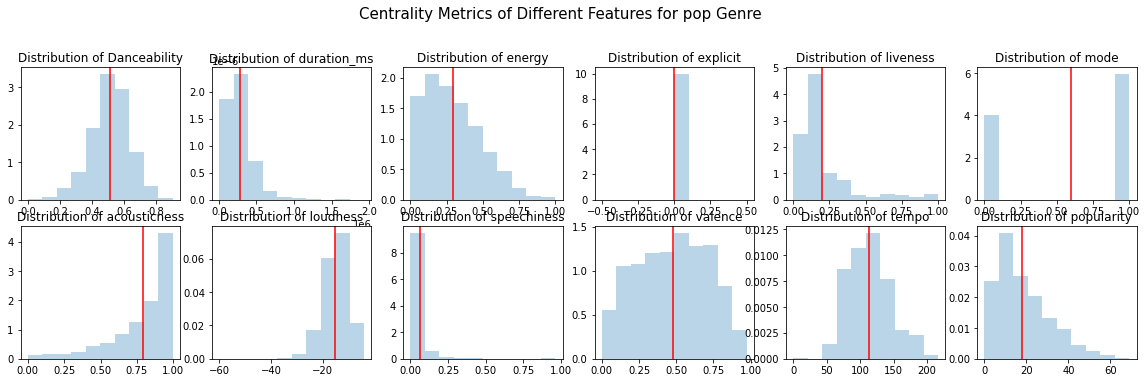

In [ ]:
filter3 = data_custom["jazz"] == True

fig, axes = plt.subplots(2, 6, figsize=(20, 6), constrained_layout=True)
fig.subplots_adjust(top=0.8)
# plot Danceability distribution and its mean
axes[0][0].set_title("Distribution of Danceability")
axes[0][0].hist(data_custom["danceability"][filter3], alpha=0.3, density=True)
axes[0][0].axvline(data_custom['danceability'][filter3].mean(), 0, 1, c="r")

# plot duration_ms distribution and its mean
axes[0][1].set_title("Distribution of duration_ms")
axes[0][1].hist(data_custom["duration_ms"][filter3], alpha=0.3, density=True)
axes[0][1].axvline(data_custom['duration_ms'][filter3].mean(), 0, 1, c="r")

# plot energy distribution and its mean
axes[0][2].set_title("Distribution of energy")
axes[0][2].hist(data_custom["energy"][filter3], alpha=0.3, density=True)
axes[0][2].axvline(data_custom['energy'][filter3].mean(), 0, 1, c="r")

# plot explicit distribution and its mean
axes[0][3].set_title("Distribution of explicit")
axes[0][3].hist(data_custom["explicit"][filter3], alpha=0.3, density=True)
axes[0][3].axvline(data_custom['explicit'][filter3].mean(), 0, 1, c="r")

# plot liveness distribution and its mean
axes[0][4].set_title("Distribution of liveness")
axes[0][4].hist(data_custom["liveness"][filter3], alpha=0.3, density=True)
axes[0][4].axvline(data_custom['liveness'][filter3].mean(), 0, 1, c="r")

# plot mode distribution and its mean
axes[0][5].set_title("Distribution of mode")
axes[0][5].hist(data_custom["mode"][filter3], alpha=0.3, density=True)
axes[0][5].axvline(data_custom['mode'][filter3].mean(), 0, 1, c="r")

# plot acousticness distribution and its mean
axes[1][0].set_title("Distribution of acousticness")
axes[1][0].hist(data_custom["acousticness"][filter3], alpha=0.3, density=True)
axes[1][0].axvline(data_custom['acousticness'][filter3].mean(), 0, 1, c="r")

# plot loudness distribution and its mean
axes[1][1].set_title("Distribution of loudness")
axes[1][1].hist(data_custom["loudness"][filter3], alpha=0.3, density=True)
axes[1][1].axvline(data_custom['loudness'][filter3].mean(), 0, 1, c="r")

# plot speechiness distribution and its mean
axes[1][2].set_title("Distribution of speechiness")
axes[1][2].hist(data_custom["speechiness"][filter3], alpha=0.3, density=True)
axes[1][2].axvline(data_custom['speechiness'][filter3].mean(), 0, 1, c="r")

# plot valence distribution and its mean
axes[1][3].set_title("Distribution of valence")
axes[1][3].hist(data_custom["valence"][filter3], alpha=0.3, density=True)
axes[1][3].axvline(data_custom['valence'][filter3].mean(), 0, 1, c="r")

# plot tempo distribution and its mean
axes[1][4].set_title("Distribution of tempo")
axes[1][4].hist(data_custom["tempo"][filter3], alpha=0.3, density=True)
axes[1][4].axvline(data_custom['tempo'][filter3].mean(), 0, 1, c="r")

# plot popularity distribution and its mean
axes[1][5].set_title("Distribution of popularity")
axes[1][5].hist(data_custom["popularity"][filter3], alpha=0.3, density=True)
axes[1][5].axvline(data_custom['popularity'][filter3].mean(), 0, 1, c="r")


fig.suptitle('Centrality Metrics of Different Features for pop Genre\n ', fontsize=15, y=0.94)


plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


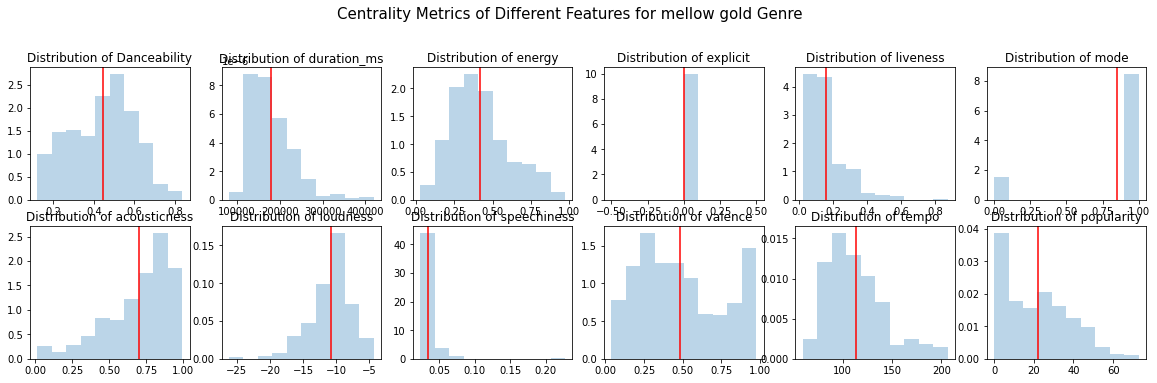

In [ ]:
filter4 = data_custom["mellow gold"] == True

fig, axes = plt.subplots(2, 6, figsize=(20, 6), constrained_layout=True)
fig.subplots_adjust(top=0.8)
# plot Danceability distribution and its mean
axes[0][0].set_title("Distribution of Danceability")
axes[0][0].hist(data_custom["danceability"][filter4], alpha=0.3, density=True)
axes[0][0].axvline(data_custom['danceability'][filter4].mean(), 0, 1, c="r")

# plot duration_ms distribution and its mean
axes[0][1].set_title("Distribution of duration_ms")
axes[0][1].hist(data_custom["duration_ms"][filter4], alpha=0.3, density=True)
axes[0][1].axvline(data_custom['duration_ms'][filter4].mean(), 0, 1, c="r")

# plot energy distribution and its mean
axes[0][2].set_title("Distribution of energy")
axes[0][2].hist(data_custom["energy"][filter4], alpha=0.3, density=True)
axes[0][2].axvline(data_custom['energy'][filter4].mean(), 0, 1, c="r")

# plot explicit distribution and its mean
axes[0][3].set_title("Distribution of explicit")
axes[0][3].hist(data_custom["explicit"][filter4], alpha=0.3, density=True)
axes[0][3].axvline(data_custom['explicit'][filter4].mean(), 0, 1, c="r")

# plot liveness distribution and its mean
axes[0][4].set_title("Distribution of liveness")
axes[0][4].hist(data_custom["liveness"][filter4], alpha=0.3, density=True)
axes[0][4].axvline(data_custom['liveness'][filter4].mean(), 0, 1, c="r")

# plot mode distribution and its mean
axes[0][5].set_title("Distribution of mode")
axes[0][5].hist(data_custom["mode"][filter4], alpha=0.3, density=True)
axes[0][5].axvline(data_custom['mode'][filter4].mean(), 0, 1, c="r")

# plot acousticness distribution and its mean
axes[1][0].set_title("Distribution of acousticness")
axes[1][0].hist(data_custom["acousticness"][filter4], alpha=0.3, density=True)
axes[1][0].axvline(data_custom['acousticness'][filter4].mean(), 0, 1, c="r")

# plot loudness distribution and its mean
axes[1][1].set_title("Distribution of loudness")
axes[1][1].hist(data_custom["loudness"][filter4], alpha=0.3, density=True)
axes[1][1].axvline(data_custom['loudness'][filter4].mean(), 0, 1, c="r")

# plot speechiness distribution and its mean
axes[1][2].set_title("Distribution of speechiness")
axes[1][2].hist(data_custom["speechiness"][filter4], alpha=0.3, density=True)
axes[1][2].axvline(data_custom['speechiness'][filter4].mean(), 0, 1, c="r")

# plot valence distribution and its mean
axes[1][3].set_title("Distribution of valence")
axes[1][3].hist(data_custom["valence"][filter4], alpha=0.3, density=True)
axes[1][3].axvline(data_custom['valence'][filter4].mean(), 0, 1, c="r")

# plot tempo distribution and its mean
axes[1][4].set_title("Distribution of tempo")
axes[1][4].hist(data_custom["tempo"][filter4], alpha=0.3, density=True)
axes[1][4].axvline(data_custom['tempo'][filter4].mean(), 0, 1, c="r")

# plot popularity distribution and its mean
axes[1][5].set_title("Distribution of popularity")
axes[1][5].hist(data_custom["popularity"][filter4], alpha=0.3, density=True)
axes[1][5].axvline(data_custom['popularity'][filter4].mean(), 0, 1, c="r")


fig.suptitle('Centrality Metrics of Different Features for mellow gold Genre\n ', fontsize=15, y=0.94)


plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


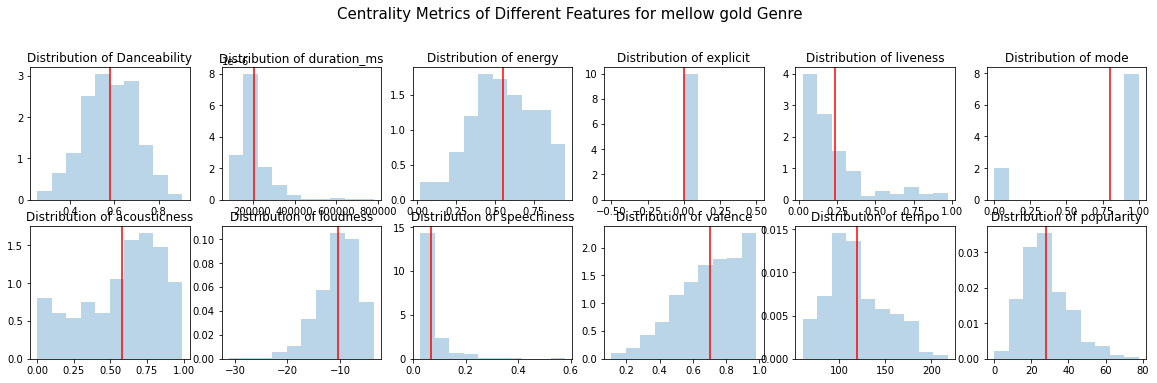

In [ ]:
filter5 = data_custom["classic rock"] == True

fig, axes = plt.subplots(2, 6, figsize=(20, 6), constrained_layout=True)
fig.subplots_adjust(top=0.8)
# plot Danceability distribution and its mean
axes[0][0].set_title("Distribution of Danceability")
axes[0][0].hist(data_custom["danceability"][filter5], alpha=0.3, density=True)
axes[0][0].axvline(data_custom['danceability'][filter5].mean(), 0, 1, c="r")

# plot duration_ms distribution and its mean
axes[0][1].set_title("Distribution of duration_ms")
axes[0][1].hist(data_custom["duration_ms"][filter5], alpha=0.3, density=True)
axes[0][1].axvline(data_custom['duration_ms'][filter5].mean(), 0, 1, c="r")

# plot energy distribution and its mean
axes[0][2].set_title("Distribution of energy")
axes[0][2].hist(data_custom["energy"][filter5], alpha=0.3, density=True)
axes[0][2].axvline(data_custom['energy'][filter5].mean(), 0, 1, c="r")

# plot explicit distribution and its mean
axes[0][3].set_title("Distribution of explicit")
axes[0][3].hist(data_custom["explicit"][filter5], alpha=0.3, density=True)
axes[0][3].axvline(data_custom['explicit'][filter5].mean(), 0, 1, c="r")

# plot liveness distribution and its mean
axes[0][4].set_title("Distribution of liveness")
axes[0][4].hist(data_custom["liveness"][filter5], alpha=0.3, density=True)
axes[0][4].axvline(data_custom['liveness'][filter5].mean(), 0, 1, c="r")

# plot mode distribution and its mean
axes[0][5].set_title("Distribution of mode")
axes[0][5].hist(data_custom["mode"][filter5], alpha=0.3, density=True)
axes[0][5].axvline(data_custom['mode'][filter5].mean(), 0, 1, c="r")

# plot acousticness distribution and its mean
axes[1][0].set_title("Distribution of acousticness")
axes[1][0].hist(data_custom["acousticness"][filter5], alpha=0.3, density=True)
axes[1][0].axvline(data_custom['acousticness'][filter5].mean(), 0, 1, c="r")

# plot loudness distribution and its mean
axes[1][1].set_title("Distribution of loudness")
axes[1][1].hist(data_custom["loudness"][filter5], alpha=0.3, density=True)
axes[1][1].axvline(data_custom['loudness'][filter5].mean(), 0, 1, c="r")

# plot speechiness distribution and its mean
axes[1][2].set_title("Distribution of speechiness")
axes[1][2].hist(data_custom["speechiness"][filter5], alpha=0.3, density=True)
axes[1][2].axvline(data_custom['speechiness'][filter5].mean(), 0, 1, c="r")

# plot valence distribution and its mean
axes[1][3].set_title("Distribution of valence")
axes[1][3].hist(data_custom["valence"][filter5], alpha=0.3, density=True)
axes[1][3].axvline(data_custom['valence'][filter5].mean(), 0, 1, c="r")

# plot tempo distribution and its mean
axes[1][4].set_title("Distribution of tempo")
axes[1][4].hist(data_custom["tempo"][filter5], alpha=0.3, density=True)
axes[1][4].axvline(data_custom['tempo'][filter5].mean(), 0, 1, c="r")

# plot popularity distribution and its mean
axes[1][5].set_title("Distribution of popularity")
axes[1][5].hist(data_custom["popularity"][filter5], alpha=0.3, density=True)
axes[1][5].axvline(data_custom['popularity'][filter5].mean(), 0, 1, c="r")


fig.suptitle('Centrality Metrics of Different Features for classic rock Genre\n ', fontsize=15, y=0.94)


plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


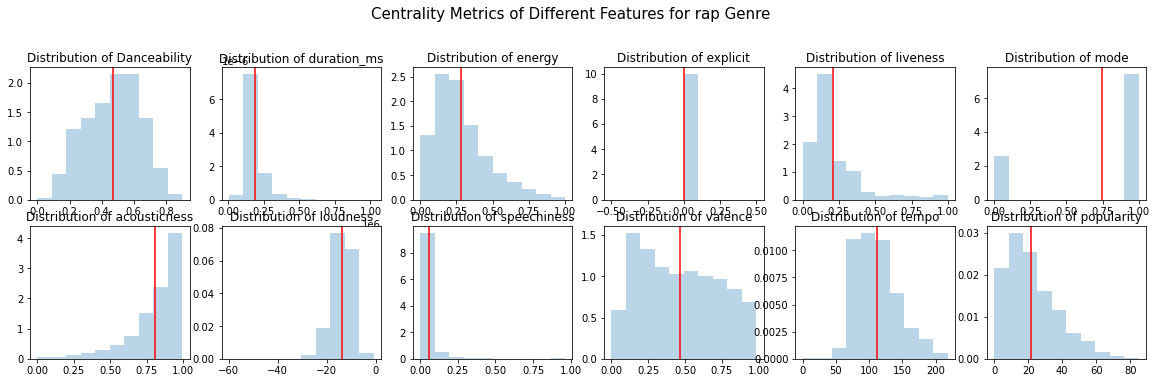

In [ ]:
filter7 = data_custom["adult standards"] == True

fig, axes = plt.subplots(2, 6, figsize=(20, 6), constrained_layout=True)
fig.subplots_adjust(top=0.8)
# plot Danceability distribution and its mean
axes[0][0].set_title("Distribution of Danceability")
axes[0][0].hist(data_custom["danceability"][filter7], alpha=0.3, density=True)
axes[0][0].axvline(data_custom['danceability'][filter7].mean(), 0, 1, c="r")

# plot duration_ms distribution and its mean
axes[0][1].set_title("Distribution of duration_ms")
axes[0][1].hist(data_custom["duration_ms"][filter7], alpha=0.3, density=True)
axes[0][1].axvline(data_custom['duration_ms'][filter7].mean(), 0, 1, c="r")

# plot energy distribution and its mean
axes[0][2].set_title("Distribution of energy")
axes[0][2].hist(data_custom["energy"][filter7], alpha=0.3, density=True)
axes[0][2].axvline(data_custom['energy'][filter7].mean(), 0, 1, c="r")

# plot explicit distribution and its mean
axes[0][3].set_title("Distribution of explicit")
axes[0][3].hist(data_custom["explicit"][filter7], alpha=0.3, density=True)
axes[0][3].axvline(data_custom['explicit'][filter7].mean(), 0, 1, c="r")

# plot liveness distribution and its mean
axes[0][4].set_title("Distribution of liveness")
axes[0][4].hist(data_custom["liveness"][filter7], alpha=0.3, density=True)
axes[0][4].axvline(data_custom['liveness'][filter7].mean(), 0, 1, c="r")

# plot mode distribution and its mean
axes[0][5].set_title("Distribution of mode")
axes[0][5].hist(data_custom["mode"][filter7], alpha=0.3, density=True)
axes[0][5].axvline(data_custom['mode'][filter7].mean(), 0, 1, c="r")

# plot acousticness distribution and its mean
axes[1][0].set_title("Distribution of acousticness")
axes[1][0].hist(data_custom["acousticness"][filter7], alpha=0.3, density=True)
axes[1][0].axvline(data_custom['acousticness'][filter7].mean(), 0, 1, c="r")

# plot loudness distribution and its mean
axes[1][1].set_title("Distribution of loudness")
axes[1][1].hist(data_custom["loudness"][filter7], alpha=0.3, density=True)
axes[1][1].axvline(data_custom['loudness'][filter7].mean(), 0, 1, c="r")

# plot speechiness distribution and its mean
axes[1][2].set_title("Distribution of speechiness")
axes[1][2].hist(data_custom["speechiness"][filter7], alpha=0.3, density=True)
axes[1][2].axvline(data_custom['speechiness'][filter7].mean(), 0, 1, c="r")

# plot valence distribution and its mean
axes[1][3].set_title("Distribution of valence")
axes[1][3].hist(data_custom["valence"][filter7], alpha=0.3, density=True)
axes[1][3].axvline(data_custom['valence'][filter7].mean(), 0, 1, c="r")

# plot tempo distribution and its mean
axes[1][4].set_title("Distribution of tempo")
axes[1][4].hist(data_custom["tempo"][filter7], alpha=0.3, density=True)
axes[1][4].axvline(data_custom['tempo'][filter7].mean(), 0, 1, c="r")

# plot popularity distribution and its mean
axes[1][5].set_title("Distribution of popularity")
axes[1][5].hist(data_custom["popularity"][filter7], alpha=0.3, density=True)
axes[1][5].axvline(data_custom['popularity'][filter7].mean(), 0, 1, c="r")


fig.suptitle('Centrality Metrics of Different Features for adult standarts Genre\n ', fontsize=15, y=0.94)


plt.show()

##Based on Years

In [ ]:
import matplotlib.pyplot as plt
year_data = data_custom.groupby(['year']).mean().reset_index()
year_data

,year,Unnamed: 0,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
0,1920,14726.732635,0.792734,0.585520,185738.055960,0.247822,0.127554,0.363918,5.310712,0.211486,-16.524738,0.692485,1.193107,0.296305,110.304984,0.545224,0.000178,0.000355,0.033043,0.000000,0.000000,0.000178,0.000000,0.122579,0.000178,0.034287,0.010126,0.012791,0.000000,0.000000,0.000000,0.010659,0.013146,0.000888,0.014212,0.006928,0.000178,0.000533,0.000000,0.000000,0.001954,0.000000,0.000000,0.047255,0.000178,0.000178
1,1930,39139.892601,0.816479,0.559372,197997.471847,0.279372,0.055840,0.241766,5.158120,0.223175,-15.285920,0.697348,2.212936,0.294912,110.923144,0.568122,0.000000,0.000093,0.089809,0.000372,0.000000,0.000000,0.000186,0.077897,0.000465,0.087855,0.045603,0.084597,0.000093,0.000000,0.001489,0.015449,0.023546,0.015821,0.023918,0.015914,0.000093,0.006049,0.000093,0.000093,0.002327,0.000093,0.000000,0.060028,0.000093,0.000093
2,1940,52014.233241,0.872016,0.474062,217787.468809,0.254222,0.068912,0.365763,5.172345,0.220767,-15.325884,0.703278,1.812399,0.152929,107.365364,0.488909,0.000582,0.000388,0.042666,0.000776,0.000323,0.000388,0.000453,0.268343,0.001487,0.034262,0.007434,0.035749,0.000129,0.000259,0.013446,0.012606,0.018359,0.018553,0.017777,0.000000,0.000129,0.000000,0.005560,0.000065,0.005495,0.000000,0.000000,0.032840,0.000065,0.000000
3,1950,60875.123446,0.838623,0.478286,219404.602988,0.285195,0.007772,0.244233,5.051645,0.210493,-14.800545,0.713598,10.739621,0.104081,110.577726,0.477645,0.002106,0.005215,0.235058,0.005716,0.000000,0.007822,0.000903,0.150421,0.007521,0.197754,0.053951,0.170227,0.001103,0.000000,0.049840,0.009276,0.167218,0.171029,0.164160,0.000050,0.000201,0.009025,0.000000,0.000050,0.000000,0.000000,0.000100,0.126554,0.004964,0.000000
4,1960,66903.550760,0.630479,0.492035,210497.340690,0.411917,0.000616,0.165346,5.097208,0.208251,-12.686085,0.754670,26.373794,0.057083,115.016295,0.548588,0.167419,0.189437,0.267502,0.115274,0.065746,0.184613,0.059074,0.036902,0.091716,0.122254,0.135496,0.132622,0.056867,0.031205,0.203038,0.086071,0.098029,0.099723,0.095617,0.138011,0.070314,0.066670,0.003747,0.011856,0.002566,0.000103,0.008007,0.039468,0.057842,0.000000
5,1970,82958.944065,0.403231,0.524654,252769.150518,0.530918,0.003417,0.117335,5.087848,0.215156,-11.442434,0.742989,34.535682,0.061621,119.710674,0.583336,0.375967,0.382702,0.089456,0.312494,0.274651,0.248367,0.264197,0.011509,0.216404,0.014725,0.113981,0.011458,0.163584,0.137552,0.040054,0.136295,0.016333,0.014172,0.014323,0.108755,0.143432,0.119610,0.006332,0.068148,0.005729,0.003367,0.050608,0.003216,0.102573,0.002915
6,1980,95760.568976,0.307505,0.544118,250847.474900,0.588954,0.023193,0.125155,5.268926,0.203525,-11.342862,0.709890,36.973143,0.061994,121.101650,0.561468,0.308986,0.177711,0.054669,0.171486,0.186044,0.076054,0.169528,0.030673,0.094177,0.012651,0.047992,0.010392,0.108283,0.134036,0.015612,0.042570,0.006677,0.006576,0.006225,0.019478,0.042319,0.031878,0.023594,0.154869,0.012249,0.019378,0.095683,0.003514,0.052209,0.019528
7,1990,107494.460054,0.318422,0.565024,247323.401727,0.578990,0.112855,0.118696,5.329435,0.195924,-10.146249,0.721984,43.132445,0.079977,119.357464,0.544546,0.167876,0.045300,0.044066,0.050037,0.044856,0.024870,0.046188,0.017666,0.058327,0.018011,0.028966,0.014508,0.028966,0.058377,0.019936,0.028226,0.009228,0.008833,0.008833,0.007895,0.023390,0.023341,0.065778,0.022699,0.029312,0.081964,0.063311,0.010363,0.026104,0.098643
8,2000,118766.672270,0.270187,0.566586,238218.575566,0.659299,0.127265,0.126576,5.254966,0.212149,-7.823843,0.686531,43.201994,0.085231,121.443743,0.5365

In [ ]:
def plot_years(year_data):
  fig, axes = plt.subplots(2, 6, figsize=(24, 12), constrained_layout=True)
  fig.subplots_adjust(top=0.8)

  # plot acousticness over year
  axes[0][0].set_title(" acousticness")
  axes[0][0].plot(year_data['year'], year_data['acousticness'])

  # plot danceability over year
  axes[0][1].set_title(" danceability ")
  axes[0][1].plot(year_data['year'], year_data['danceability'])

  # plot duration_ms over year
  axes[0][2].set_title(" duration_ms ")
  axes[0][2].plot(year_data['year'], year_data['duration_ms'])

  # plot energy over year
  axes[0][3].set_title(" energy")
  axes[0][3].plot(year_data['year'], year_data['energy'])

  # plot explicit over year
  axes[0][4].set_title(" explicit ")
  axes[0][4].plot(year_data['year'], year_data['explicit'])

  # plot valence over year
  axes[0][5].set_title(" valence ")
  axes[0][5].plot(year_data['year'], year_data['valence'])

  # plot instrumentalness over year
  axes[1][0].set_title(" instrumentalness ")
  axes[1][0].plot(year_data['year'], year_data['instrumentalness'])

  # plot liveness over year
  axes[1][1].set_title(" liveness ")
  axes[1][1].plot(year_data['year'], year_data['liveness'])

  # plot mode over year
  axes[1][2].set_title(" mode ")
  axes[1][2].plot(year_data['year'], year_data['mode'])

  # plot speechiness over year
  axes[1][3].set_title(" speechiness")
  axes[1][3].plot(year_data['year'], year_data['speechiness'])

  # plot tempo over year
  axes[1][4].set_title(" tempo ")
  axes[1][4].plot(year_data['year'], year_data['tempo'])

  # plot popularity over year
  axes[1][5].set_title(" popularity ")
  axes[1][5].plot(year_data['year'], year_data['popularity'])


  fig.suptitle('Change of features over Years', fontsize=25, y=0.90)
  fig.text(0.5, 0.04, 'YEAR', ha='center', fontsize = 30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


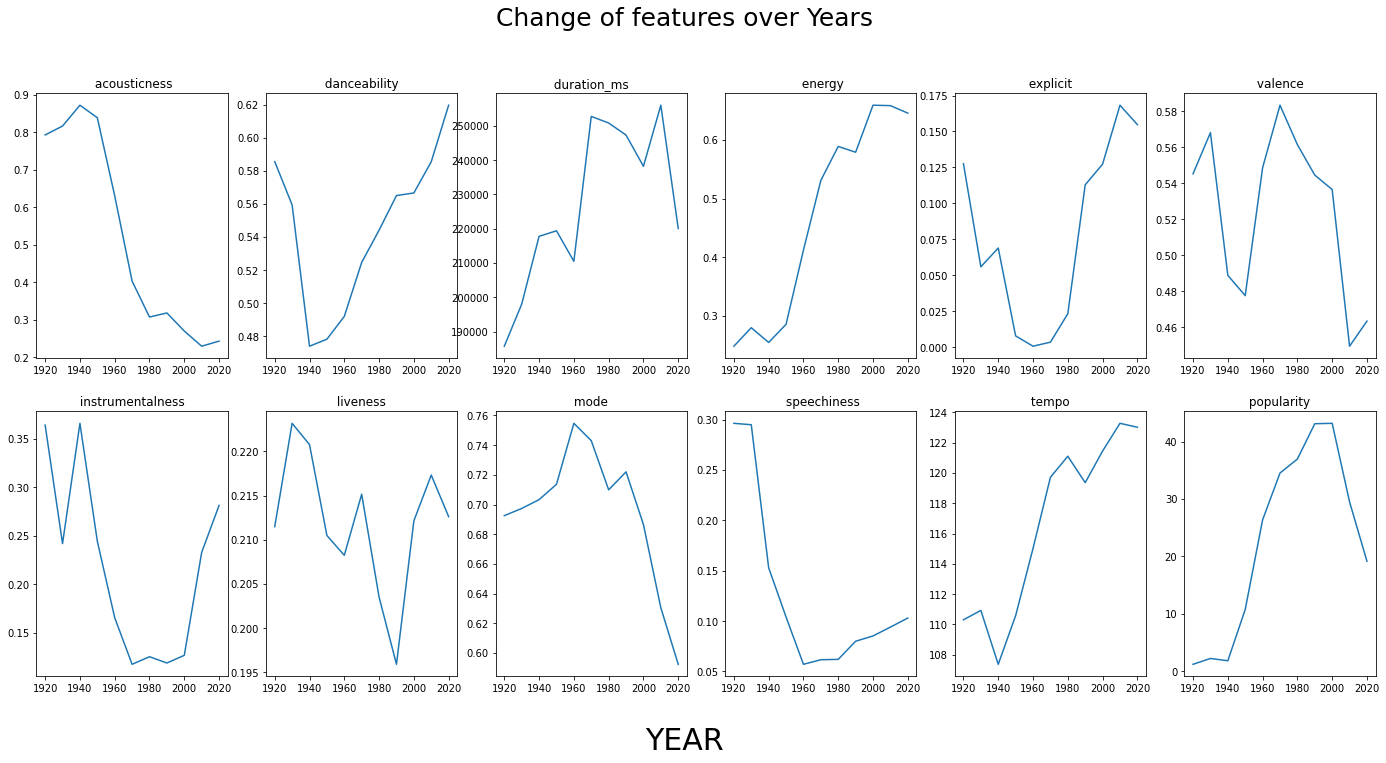

In [ ]:
plot_years(year_data)

#3. Analysis of the most popular artists and songs.

In [ ]:
data_custom.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
count,173600.000000,173600.000000,173600.000000,1.736000e+05,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000,173600.000000
mean,86799.500000,0.499323,0.536732,2.327701e+05,0.482870,0.068145,0.197574,5.204965,0.211095,-11.744242,0.702385,25.667212,0.105867,117.017184,0.524488,1972.587154,0.132350,0.097218,0.094435,0.080000,0.070259,0.066832,0.066025,0.063468,0.058041,0.052235,0.048779,0.048704,0.044649,0.044643,0.041976,0.038341,0.038318,0.037742,0.037350,0.035225,0.034130,0.032281,0.032108,0.031452,0.031342,0.030593,0.030328,0.029366,0.029050,0.028986
std,50114.147703,0.380113,0.176113,1.484135e+05,0.272819,0.251996,0.334782,3.518302,0.180409,5.693265,0.457211,21.885704,0.182537,30.263679,0.264569,27.104537,0.338872,0.296255,0.292434,0.271294,0.255584,0.249731,0.248327,0.243803,0.233823,0.222501,0.215406,0.215249,0.206532,0.206519,0.200534,0.192019,0.191963,0.190572,0.189619,0.184348,0.181564,0.176746,0.176288,0.174535,0.174241,0.172214,0.171490,0.168832,0.167946,0.167768
min,0.000000,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43399.750000,0.087300,0.414000,1.661070e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.904000,0.000000,1.000000,0.035200,93.938750,0.310000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,86799.500000,0.518000,0.548000,2.057730e+05,0.465000,0.000000,0.000526,5.000000,0.138000,-10.828000,1.000000,25.000000,0.045500,115.825000,0.536000,1970.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,130199.250000,0.895000,0.669000,2.656800e+05,0.711000,0.000000,0.254000,8.000000,0.270000,-7.489000,1.000000,42.000000,0.076400,135.015000,0.744000,1990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,173599.000000,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

In [ ]:
df = data_custom.sort_values('popularity', ascending = False)
df[['artists','name','popularity']].head(50)

,artists,name,popularity
35417,Andy Williams,It's the Most Wonderful Time of the Year,85.0
8407,Frank Sinatra,Let It Snow! Let It Snow! Let It Snow! (with T...,84.0
8962,Bing Crosby,White Christmas,80.0
23046,The Pogues,Fairytale of New York (feat. Kirsty MacColl),78.0
32277,Bill Withers,Ain't No Sunshine,77.0
36886,Dolly Parton,9 to 5,76.0
32284,Bill Withers,Lovely Day,75.0
27894,Johnny Cash,Hurt,75.0
9018,Bing Crosby,Do You Hear What I Hear? - Remastered 2006,75.0
26791,Aretha Franklin,I Say a Little Prayer,75.0


In [ ]:
from collections import Counter
list1 = (Counter(df['artists'].values).most_common(10))
print(list1)

[('Francisco Canaro', 2228), ('Tadeusz Dolega Mostowicz', 1281), ('Эрнест Хемингуэй', 1175), ('Эрих Мария Ремарк', 1062), ('Frédéric Chopin', 1012), ('Wolfgang Amadeus Mozart', 915), ('Johann Sebastian Bach', 895), ('Ludwig van Beethoven', 891), ('Frank Sinatra', 731), ('Georgette Heyer', 690)]


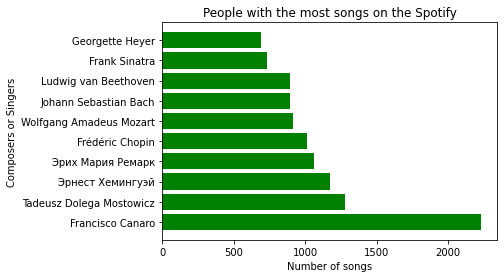

In [ ]:
import matplotlib.pyplot as plt
bar_plot = dict(Counter(df['artists'].values).most_common(10))
plt.barh(*zip(*bar_plot.items()),color='green')

plt.xlabel("Number of songs")
plt.ylabel("Composers or Singers")
plt.title("People with the most songs on the Spotify")

plt.show()

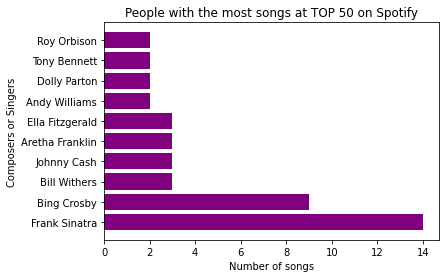

In [ ]:
bar_plot_two = dict(Counter(df['artists'].head(50)).most_common(10))
plt.barh(*zip(*bar_plot_two.items()),color = 'purple')

plt.xlabel("Number of songs")
plt.ylabel("Composers or Singers")
plt.title("People with the most songs at TOP 50 on Spotify")

plt.show()

In [ ]:
df.groupby(by = 'jazz')['popularity'].mean()

jazz
0.0     5.558497
1.0    10.472231
Name: popularity, dtype: float64

#4. Analyzing how songs of different genres change with time

##Rock 

In [ ]:
data_custom[["acousticness","energy","popularity","duration_ms","instrumentalness","explicit","liveness","loudness","mode","speechiness","tempo","valence","danceability"]].max()

acousticness              0.996
energy                    1.000
popularity              100.000
duration_ms         5338302.000
instrumentalness          1.000
explicit                  1.000
liveness                  1.000
loudness                  3.855
mode                      1.000
speechiness               0.971
tempo                   243.507
valence                   1.000
danceability              0.988
dtype: float64

In [ ]:
data_custom[["acousticness","energy","popularity","duration_ms","instrumentalness","explicit","liveness","loudness","mode","speechiness","tempo","valence","danceability"]].min()

acousticness           0.0
energy                 0.0
popularity             0.0
duration_ms         4937.0
instrumentalness       0.0
explicit               0.0
liveness               0.0
loudness             -60.0
mode                   0.0
speechiness            0.0
tempo                  0.0
valence                0.0
danceability           0.0
dtype: float64

In [ ]:
rock_data = data_custom.loc[data_custom['rock']==1]
rock_data = rock_data.groupby(['year']).mean().reset_index()
rock_data

,year,Unnamed: 0,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,rock,classic rock,adult standards,mellow gold,album rock,folk rock,soft rock,classical,country rock,vocal jazz,soul,lounge,art rock,hard rock,brill building pop,folk,jazz,cool jazz,bebop,psychedelic rock,roots rock,blues rock,dance pop,dance rock,pop,rap,permanent wave,swing,funk,hip hop
0,1920,121573.000000,0.791000,0.494000,126642.000000,0.584000,0.000000,0.044500,1.000000,0.104000,-10.902000,1.000000,0.000000,0.239000,84.273000,0.443000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
1,1940,135289.111111,0.979222,0.487778,157538.666667,0.247578,0.000000,0.469438,6.222222,0.353022,-14.977556,0.888889,0.111111,0.139167,98.273000,0.593889,1.0,0.444444,0.000000,0.444444,0.444444,0.000000,0.444444,0.0,0.000000,0.0,0.000000,0.0,0.111111,0.444444,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.111111,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
2,1950,53992.357143,0.670562,0.606667,169301.857143,0.596333,0.000000,0.156563,3.904762,0.179190,-9.806857,0.714286,29.428571,0.064743,122.621619,0.742595,1.0,0.952381,0.857143,0.095238,0.000000,0.095238,0.047619,0.0,0.047619,0.0,0.857143,0.0,0.047619,0.000000,0.047619,0.095238,0.0,0.0,0.0,0.023810,0.047619,0.880952,0.000000,0.000000,0.00000,0.000000,0.047619,0.0,0.000000,0.000000
3,1960,59983.736971,0.397444,0.489972,208885.516248,0.546655,0.000307,0.113034,5.287247,0.217560,-10.651472,0.796444,31.999080,0.054052,121.207522,0.582399,1.0,0.980687,0.022379,0.448498,0.378602,0.636726,0.213366,0.0,0.320969,0.0,0.026977,0.0,0.272532,0.178725,0.235745,0.256591,0.0,0.0,0.0,0.655120,0.367259,0.267014,0.000000,0.057020,0.00000,0.000000,0.038320,0.0,0.008277,0.000000
4,1970,70940.103596,0.298493,0.497025,258206.680524,0.595965,0.003208,0.104108,5.014838,0.241683,-10.614372,0.776768,35.356369,0.055976,123.663319,0.570165,1.0,0.913915,0.018981,0.556476,0.674509,0.440182,0.451678,0.0,0.307847,0.0,0.012164,0.0,0.350087,0.356503,0.041839,0.174709,0.0,0.0,0.0,0.246758,0.275097,0.262532,0.000000,0.125919,0.00000,0.000000,0.122978,0.0,0.005882,0.000000
5,1980,83204.726401,0.142402,0.505194,261441.652478,0.724869,0.025833,0.103890,5.260276,0.249930,-9.217808,0.714379,37.498944,0.058446,125.779176,0.551194,1.0,0.536637,0.003574,0.355483,0.542648,0.167506,0.323802,0.0,0.127376,0.0,0.002762,0.0,0.242080,0.404062,0.008936,0.056539,0.0,0.0,0.0,0.060114,0.091633,0.083997,0.004062,0.258976,0.00000,0.005686,0.258489,0.0,0.000162,0.005686
6,1990,93299.422986,0.135729,0.474373,270201.791005,0.719905,0.105820,0.124056,5.213698,0.224604,-8.343969,0.742504,44.440329,0.061236,123.144185,0.458327,1.0,0.246620,0.004409,0.158142,0.246914,0.074074,0.124633,0.0,0.080247,0.0,0.001176,0.0,0.123751,0.325691,0.004997,0.034685,0.0,0.0,0.0,0.040270,0.065256,0.105526,0.004115,0.069665,0.00000,0.016755,0.265432,0.0,0.000294,0.016755
7,2000,101436.152699,0.147168,0.494053,249687.470881,0.741160,0.062500,0.098885,5.212358,0.216116,-6.499491,0.716619,49.310369,0.057778,125.775295,0.491788,1.0,0.234375,0.004972,0.136364,0.161222,0.096591,0.116477,0.0,0.061080,0.0,0.001420,0.0,0.089489,0.107244,0.004972,0.024858,0.0,0.0,0.0,0.048295,0.058949,0.097301,0.001420,0.048295,0.00000,0.000710,0.343040,0.0,0.008523,0.000710
8,2010,95742.317218,0.162408,0.512092,242057.628499,0.697014,0.037320,0.073472,5.117897,0.224762,-7.940014,0.700594,30.935539,0.058244,123.986557,0.529488,1.0,0.506361,0.000848,0.220526,0.435963,0.151824,0.212892,0.0,0.208651,0.0,0.000848,0.0,0.365564,0.290925,0.055980,0.039864,0.0,0.0,0.0,0.220526,0.041561,0.191688,0.009330,0.143342,0.02799,0.000848,0.192536,0.0,0.006785,0.000848
9,2020,79177.567568,0.349028,0.524757,222849.567568,0.623703,0.054054,0.022517,4.351351,0.298008,-9.

In [ ]:
def plot_features(rock_data, genre):
  fig, axes = plt.subplots(2, 6, figsize=(24, 12), constrained_layout=True)
  fig.subplots_adjust(top=0.8)

  # plot acousticness over year
  axes[0][0].set_title(" acousticness")
  axes[0][0].plot(rock_data['year'], rock_data['acousticness'])
  axes[0][0].set_ylim(0,1)

  # plot danceability over year
  axes[0][1].set_title(" danceability ")
  axes[0][1].plot(rock_data['year'], rock_data['danceability'])
  axes[0][1].set_ylim(0,1)

  # plot duration_ms over year
  axes[0][2].set_title(" duration_ms ")
  axes[0][2].plot(rock_data['year'], rock_data['duration_ms'])
  axes[0][2].set_ylim(4000,550000)

  # plot energy over year
  axes[0][3].set_title(" energy")
  axes[0][3].plot(rock_data['year'], rock_data['energy'])
  axes[0][3].set_ylim(0,1)

  # plot explicit over year
  axes[0][4].set_title(" explicit ")
  axes[0][4].plot(rock_data['year'], rock_data['explicit'])
  axes[0][4].set_ylim(0,1)

  # plot valence over year
  axes[0][5].set_title(" valence ")
  axes[0][5].plot(rock_data['year'], rock_data['valence'])
  axes[0][5].set_ylim(0,1)

  # plot instrumentalness over year
  axes[1][0].set_title(" instrumentalness ")
  axes[1][0].plot(rock_data['year'], rock_data['instrumentalness'])
  axes[1][0].set_ylim(0,1)

  # plot liveness over year
  axes[1][1].set_title(" liveness ")
  axes[1][1].plot(rock_data['year'], rock_data['liveness'])
  axes[1][1].set_ylim(0,1)

  # plot mode over year
  axes[1][2].set_title(" mode ")
  axes[1][2].plot(rock_data['year'], rock_data['mode'])
  axes[1][2].set_ylim(0,1)

  # plot speechiness over year
  axes[1][3].set_title(" speechiness")
  axes[1][3].plot(rock_data['year'], rock_data['speechiness'])
  axes[1][3].set_ylim(0,1)

  # plot tempo over year
  axes[1][4].set_title(" tempo ")
  axes[1][4].plot(rock_data['year'], rock_data['tempo'])
  axes[1][4].set_ylim(0,250)


  # plot popularity over year
  axes[1][5].set_title(" popularity ")
  axes[1][5].plot(rock_data['year'], rock_data['popularity'])
  axes[1][5].set_ylim(0,100)


  fig.suptitle('Change of '+ genre +' Genre over Years', fontsize=25, y=0.90)
  fig.text(0.5, 0.04, 'YEAR', ha='center', fontsize = 30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


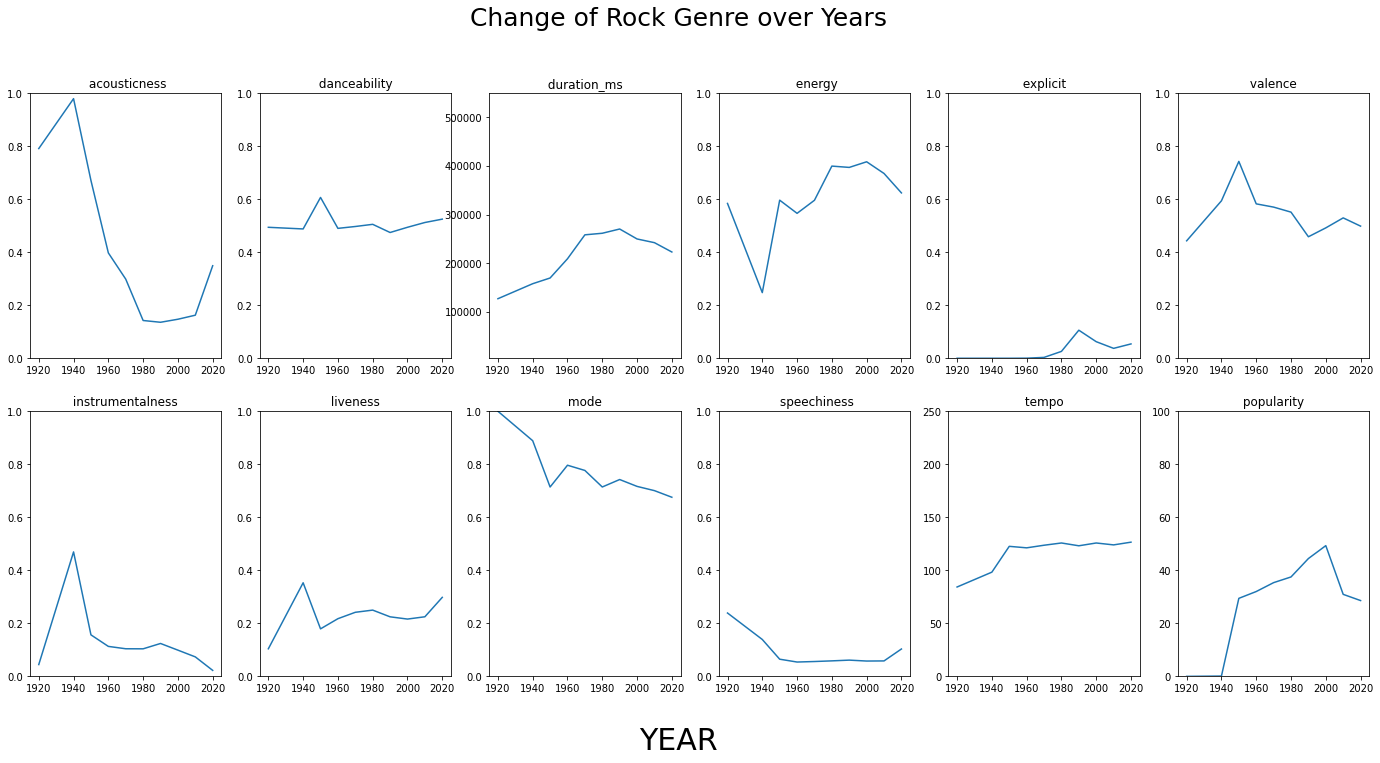

In [ ]:
plot_features(rock_data,'Rock')

##Classic Rock

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


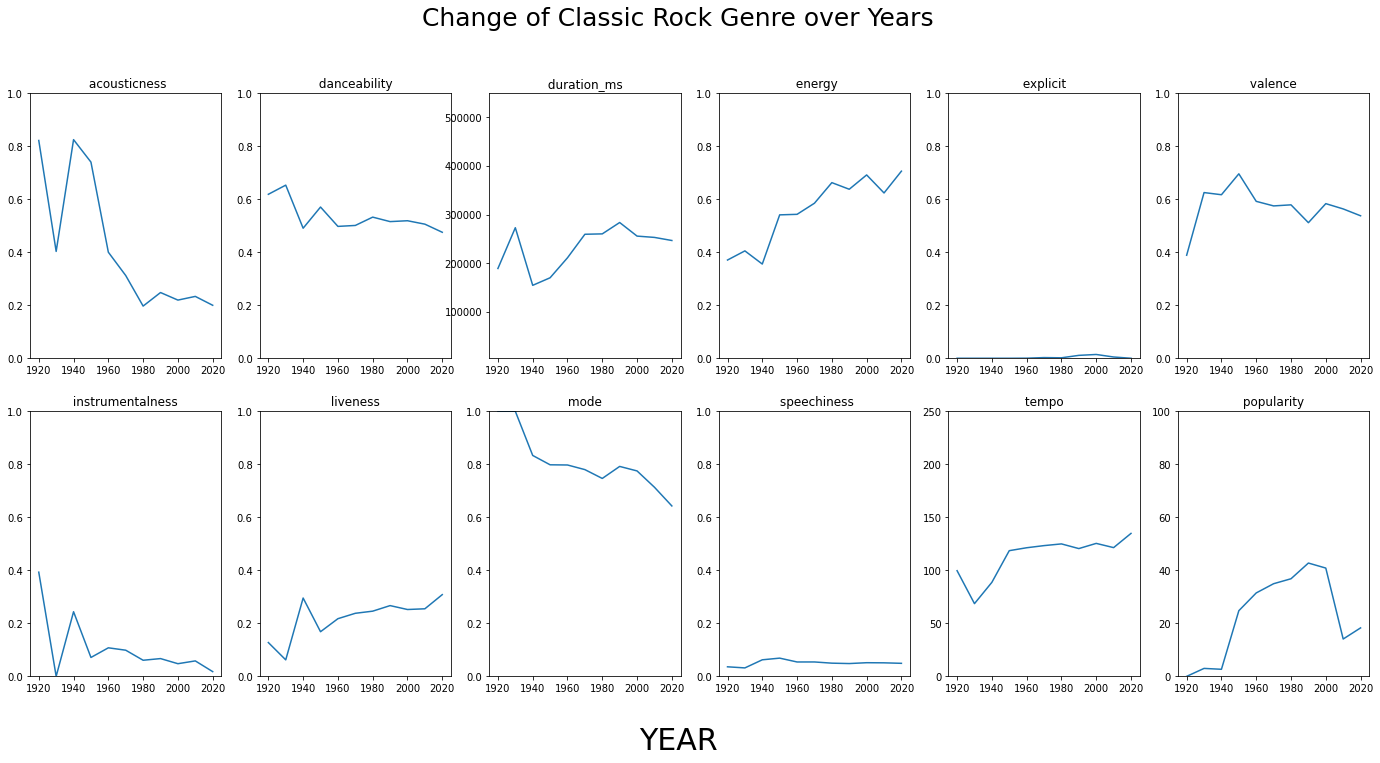

In [ ]:
rock_data = data_custom.loc[data_custom['classic rock']==1]
rock_data = rock_data.groupby(['year']).mean().reset_index()
plot_features(rock_data,'Classic Rock')

##Jazz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


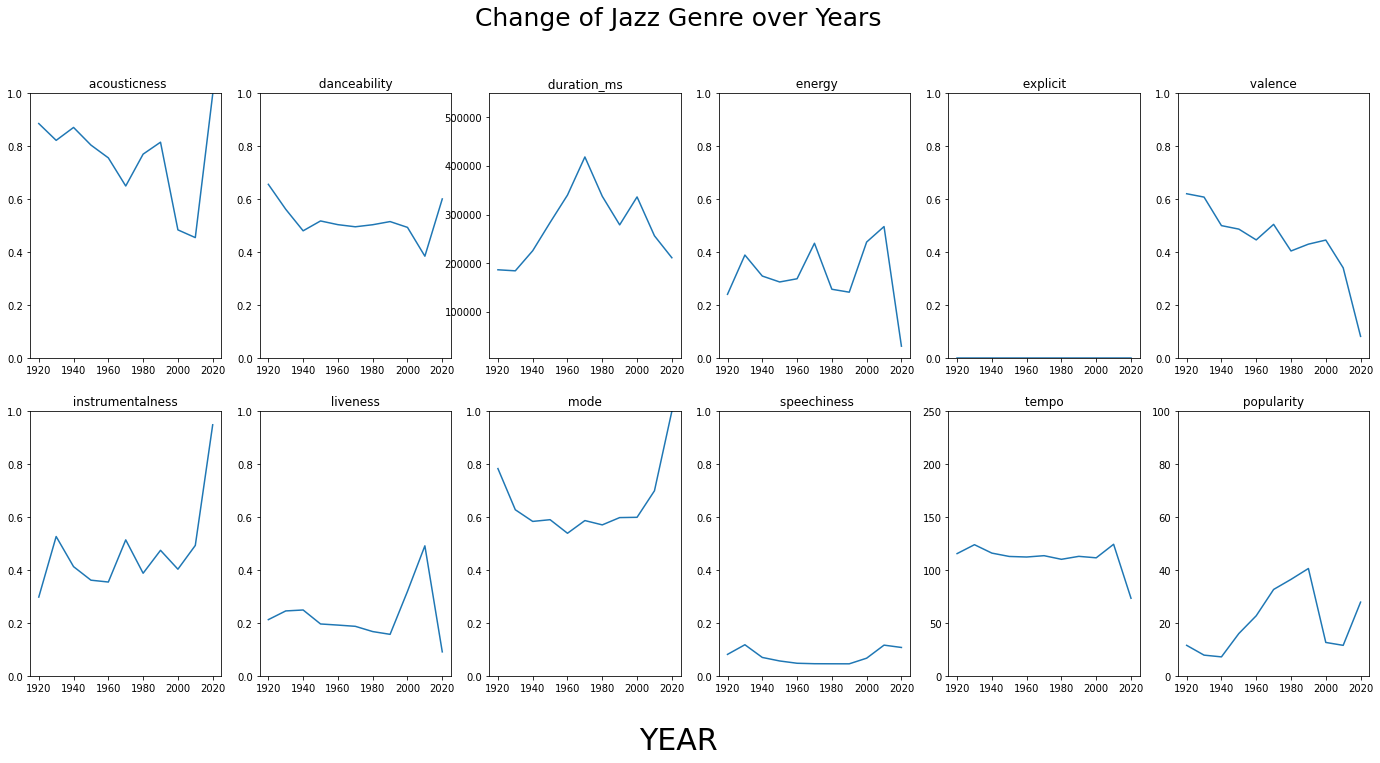

In [ ]:
rock_data = data_custom.loc[data_custom['jazz']==1]
rock_data = rock_data.groupby(['year']).mean().reset_index()
plot_features(rock_data,'Jazz')

##Pop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


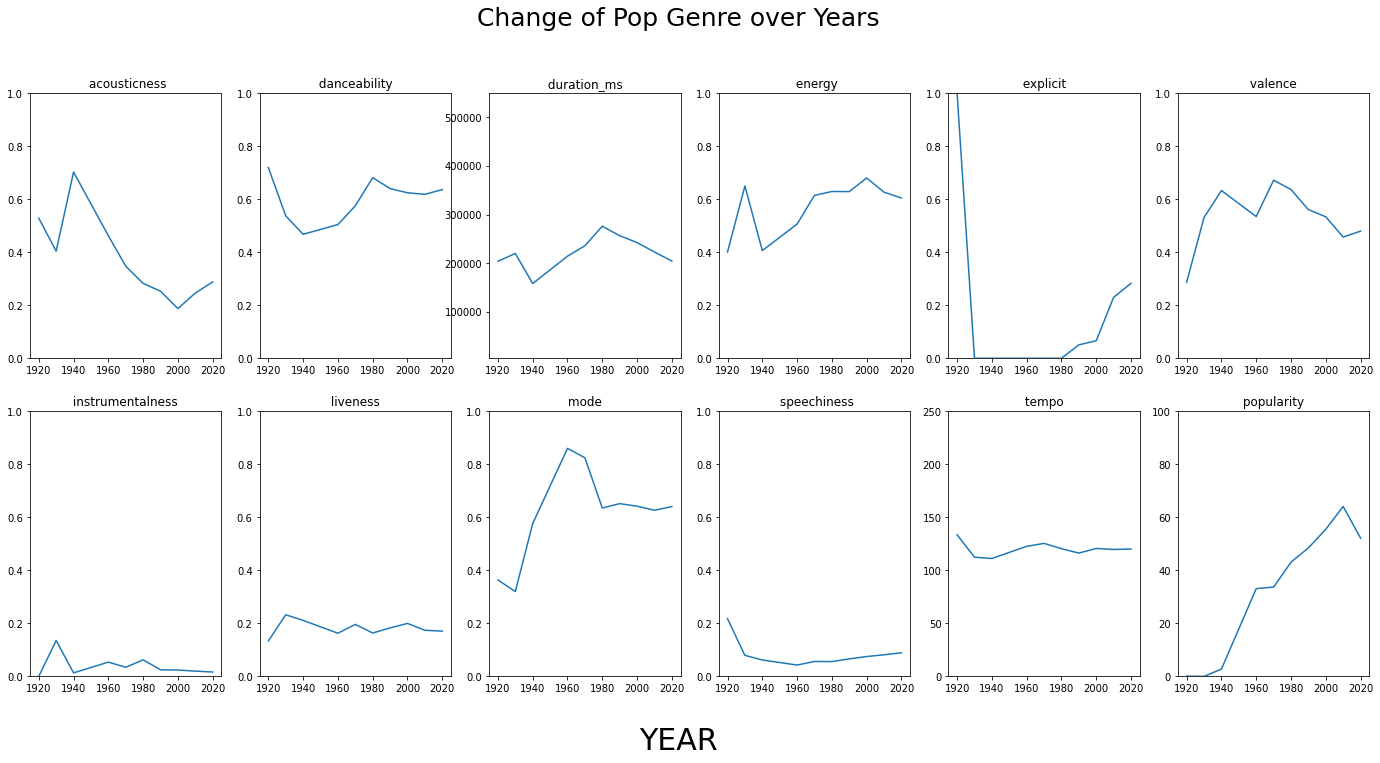

In [ ]:
rock_data = data_custom.loc[data_custom['pop']==1]
rock_data = rock_data.groupby(['year']).mean().reset_index()
plot_features(rock_data,'Pop')

##Rap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


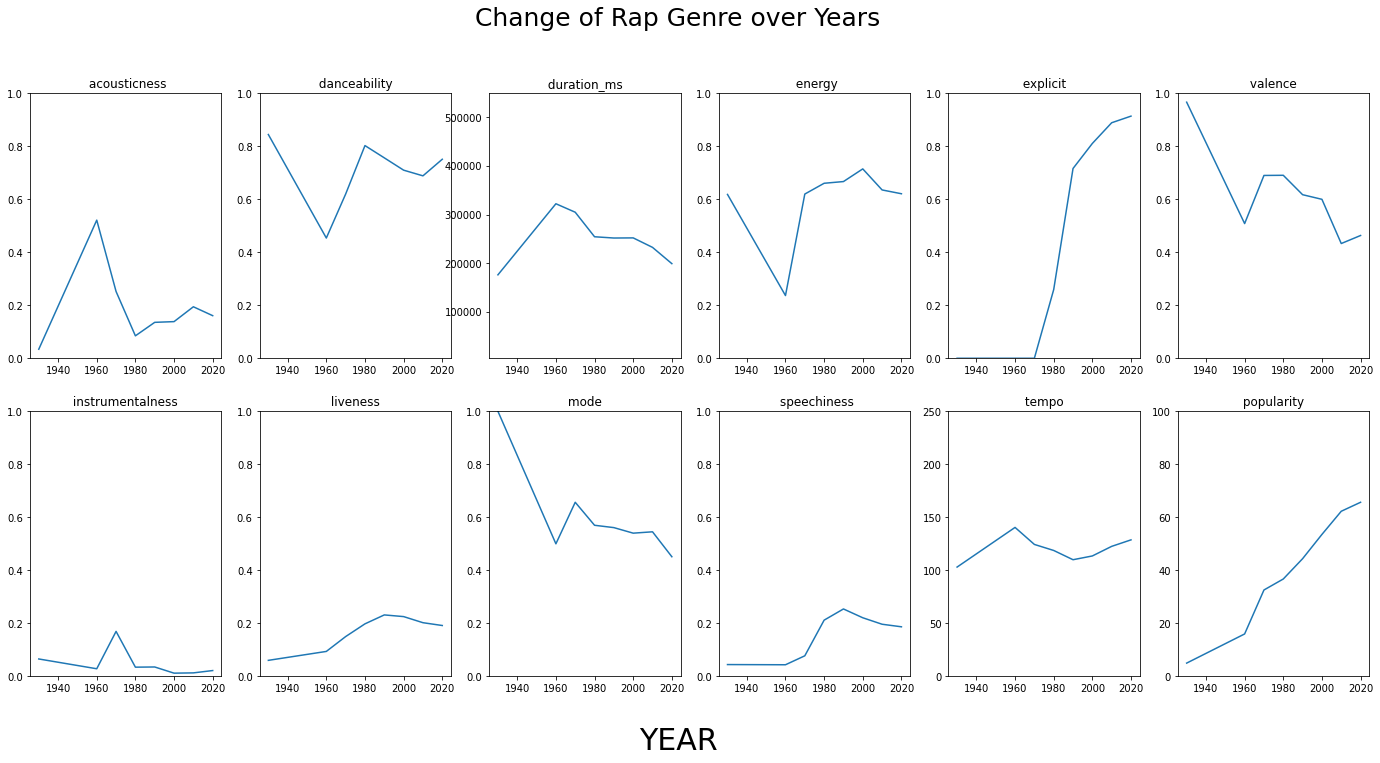

In [ ]:
rock_data = data_custom.loc[data_custom['rap']==1]
rock_data = rock_data.groupby(['year']).mean().reset_index()
plot_features(rock_data,'Rap')

##Adult Standards




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


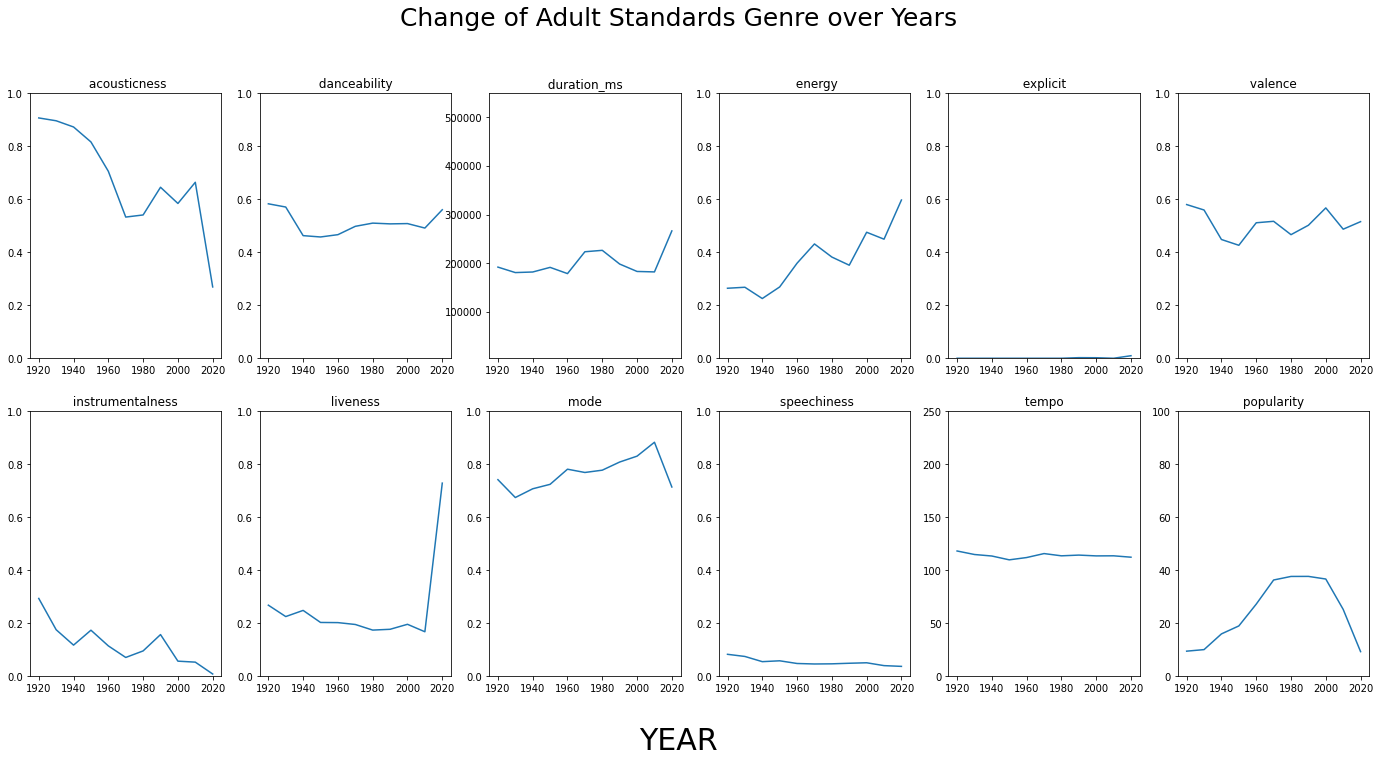

In [ ]:
rock_data = data_custom.loc[data_custom['adult standards']==1]
rock_data = rock_data.groupby(['year']).mean().reset_index()
plot_features(rock_data,'Adult Standards')

##Mellow Gold

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


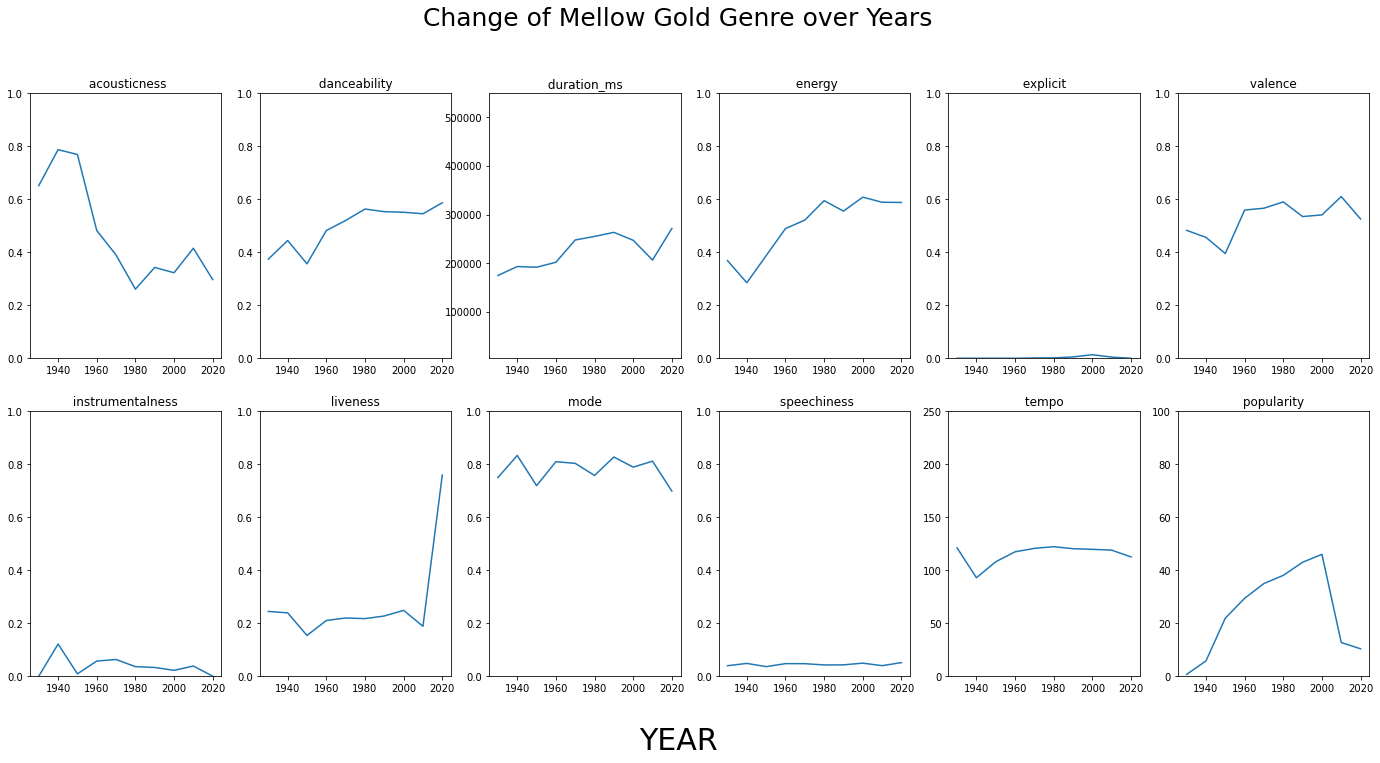

In [ ]:
rock_data = data_custom.loc[data_custom['mellow gold']==1]
rock_data = rock_data.groupby(['year']).mean().reset_index()
plot_features(rock_data,'Mellow Gold')